# Table of Contents
 <p><div class="lev1 toc-item"><a data-toc-modified-id="simple-divergence-model-1" href="#simple-divergence-model"><span class="toc-item-num">1&nbsp;&nbsp;</span>simple divergence model</a></div><div class="lev2 toc-item"><a data-toc-modified-id="plot-residuals-11" href="#plot-residuals"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>plot residuals</a></div><div class="lev1 toc-item"><a data-toc-modified-id="divergence-with-migration-model-2" href="#divergence-with-migration-model"><span class="toc-item-num">2&nbsp;&nbsp;</span>divergence with migration model</a></div><div class="lev2 toc-item"><a data-toc-modified-id="plot-21" href="#plot"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>plot</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Translation-of-m-22" href="#Translation-of-m"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Translation of <em>m</em></a></div><div class="lev2 toc-item"><a data-toc-modified-id="LRT-23" href="#LRT"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LRT</a></div><div class="lev1 toc-item"><a data-toc-modified-id="Recent-secondary-contact-model-3" href="#Recent-secondary-contact-model"><span class="toc-item-num">3&nbsp;&nbsp;</span>Recent secondary contact model</a></div><div class="lev2 toc-item"><a data-toc-modified-id="plot-residuals-31" href="#plot-residuals"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>plot residuals</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Compare-best-fit-IM-with-RSC-model-spectrum-32" href="#Compare-best-fit-IM-with-RSC-model-spectrum"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Compare best fit IM with RSC model spectrum</a></div><div class="lev1 toc-item"><a data-toc-modified-id="different-migration-rates-for-each-direction-4" href="#different-migration-rates-for-each-direction"><span class="toc-item-num">4&nbsp;&nbsp;</span>different migration rates for each direction</a></div><div class="lev2 toc-item"><a data-toc-modified-id="plain-English-41" href="#plain-English"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>plain English</a></div><div class="lev2 toc-item"><a data-toc-modified-id="LRT-42" href="#LRT"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LRT</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Is-the-migration-rate-from-ery-into-par-(m1)-statistically-significant?-43" href="#Is-the-migration-rate-from-ery-into-par-(m1)-statistically-significant?"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Is the migration rate from ery into par (<em>m1</em>) statistically significant?</a></div><div class="lev2 toc-item"><a data-toc-modified-id="plot-44" href="#plot"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>plot</a></div><div class="lev1 toc-item"><a data-toc-modified-id="two-size-changes-after-split-5" href="#two-size-changes-after-split"><span class="toc-item-num">5&nbsp;&nbsp;</span>two size changes after split</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Plot-51" href="#Plot"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Plot</a></div><div class="lev1 toc-item"><a data-toc-modified-id="Ancient-migration-model-6" href="#Ancient-migration-model"><span class="toc-item-num">6&nbsp;&nbsp;</span>Ancient migration model</a></div><div class="lev2 toc-item"><a data-toc-modified-id="plot-61" href="#plot"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>plot</a></div><div class="lev2 toc-item"><a data-toc-modified-id="plain-English-62" href="#plain-English"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>plain English</a></div><div class="lev2 toc-item"><a data-toc-modified-id="comparison-with-split_asym_mig-63" href="#comparison-with-split_asym_mig"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>comparison with <code>split_asym_mig</code></a></div>

In [1]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [2]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

error in importing Two Locus modules
[stdout:0] error in importing Two Locus modules
[stdout:1] error in importing Two Locus modules
[stdout:2] error in importing Two Locus modules
[stdout:3] error in importing Two Locus modules
[stdout:4] error in importing Two Locus modules
[stdout:5] error in importing Two Locus modules
[stdout:6] error in importing Two Locus modules
[stdout:7] error in importing Two Locus modules
[stdout:8] error in importing Two Locus modules
[stdout:9] error in importing Two Locus modules
[stdout:10] error in importing Two Locus modules
[stdout:11] error in importing Two Locus modules
[stdout:12] error in importing Two Locus modules
[stdout:13] error in importing Two Locus modules
[stdout:14] error in importing Two Locus modules
[stdout:15] error in importing Two Locus modules
[stdout:16] error in importing Two Locus modules
[stdout:17] error in importing Two Locus modules
[stdout:18] error in importing Two Locus modules
[stdout:19] error in importing Two Locus m

In [13]:
%ll dadiExercises/

total 33676
lrwxrwxrwx 1 claudius       53 Feb 17 15:37 ERY.FOLDED.sfs -> /data3/claudius/Big_Data/ANGSD/SFS/ERY/ERY.FOLDED.sfs
-rw-rw-r-- 1 claudius      499 Mar 24 14:04 ERY.FOLDED.sfs.dadi_format
-rw-rw-r-- 1 claudius      499 Mar 24 14:02 ERY.FOLDED.sfs.dadi_format~
lrwxrwxrwx 1 claudius       37 Feb 18 17:46 EryPar.unfolded.2dsfs -> ../../ANGSD/FST/EryPar.unfolded.2dsfs
-rw-rw-r-- 1 claudius    13051 Feb 18 19:00 EryPar.unfolded.2dsfs.dadi_format
-rw-rw-r-- 1 claudius    13051 Feb 18 18:31 EryPar.unfolded.2dsfs.dadi_format~
drwxrwxr-x 5 claudius     4096 Feb 17 13:45 examples/
-rw-rw-r-- 1 claudius   155251 Mar 22 12:37 example_YRI_CEU.ipynb
-rw-rw-r-- 1 claudius   619699 Apr 20 10:19 First_Steps_with_dadi.ipynb
-rw-rw-r-- 1 claudius     1012 Mar 16 09:54 new.bib
lrwxrwxrwx 1 claudius       53 Feb 17 15:37 PAR.FOLDED.sfs -> /data3/claudius/Big_Data/ANGSD/SFS/PAR/PAR.FOLDED.sfs
-rw-rw-r-- 1 claudius      486 Mar 24 20:08 PAR.FOLDED.sfs.dadi_format
-rw-rw-r-- 1 claudius      450 Mar

In [14]:
%less dadiExercises/EryPar.unfolded.2dsfs.dadi_format

In [3]:
# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

In [16]:
%page sfs2d_unfolded

In [4]:
sfs2d_unfolded.sample_sizes

array([36, 36])

In [5]:
# add population labels
sfs2d_unfolded.pop_ids = ["ery", "par"]

**For the estimation of the 2D SFS, `realSFS` has only taken sites that had data from at least 9 individuals in *each* population (see [`assembly.sh`](https://github.com/claudiuskerth/PhDthesis/blob/master/Data_analysis/SNP-indel-calling/assembly.sh), lines 1430 onwards).**

In [6]:
# print number of segregating sites in the SFS

sfs2d_unfolded.S()

60573.584426000001

The 2D spectrum contains counts from 60k sites that are variable in *par* or *ery* or both.

In [7]:
import pylab

%matplotlib inline

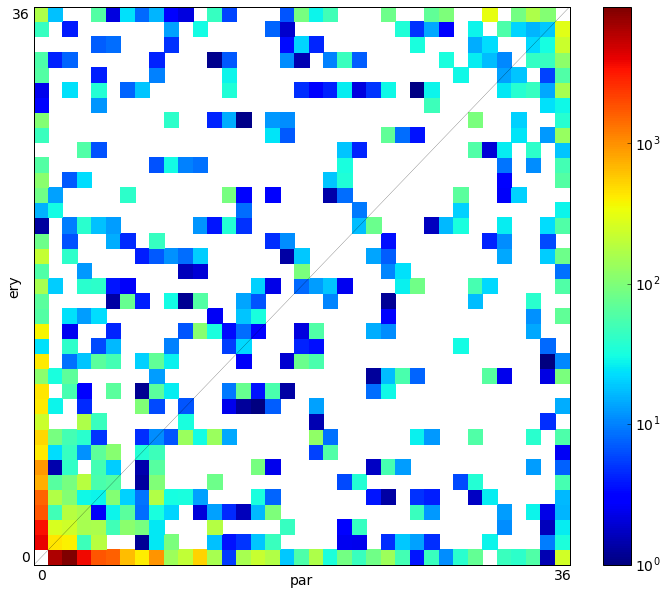

In [8]:
# note this needs to be in the same cell as the dadi plotting function call to take effect
pylab.rcParams['font.size'] = 14.0
pylab.rcParams['figure.figsize'] = [12.0, 10.0]

dadi.Plotting.plot_single_2d_sfs(sfs2d_unfolded, vmin=1, cmap=pylab.cm.jet)

Cells with counts below 1 are masked and appear white in the upper plot.

In [22]:
%psource dadi.Plotting.plot_single_2d_sfs

[More colormaps](http://www.scipy-lectures.org/intro/matplotlib/index.html#colormaps)

In [9]:
sfs2d_folded = sfs2d_unfolded.fold()

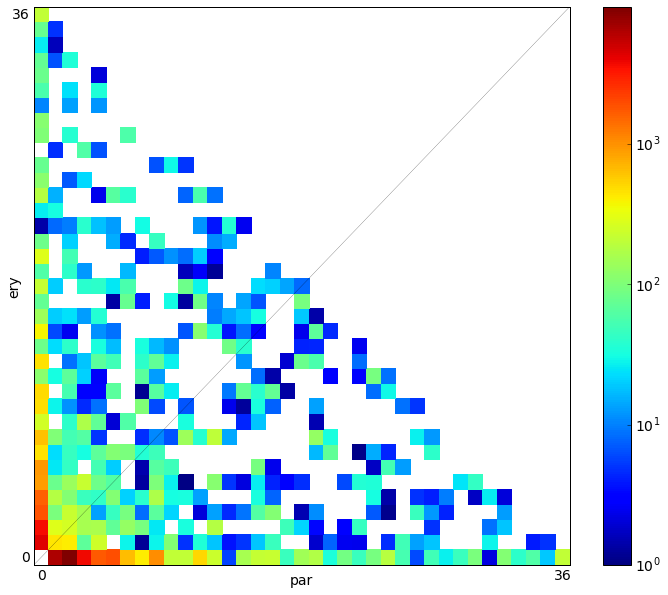

In [10]:
# plot the folded GLOBAL minor allele frequency spectrum

dadi.Plotting.plot_single_2d_sfs(sfs2d_folded, vmin=1, cmap=pylab.cm.jet)

In [11]:
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]

In [16]:
%pinfo dadi.Demographics2D.split_mig

The 1D model fitting has indicated that both _erythropus_ and _parallelus_ underwent population size reduction, maybe starting a long time ago (>400,000 generations).

In [17]:
%psource dadi.Demographics2D.split_mig

In [18]:
%psource dadi.Integration.two_pops

# simple divergence model

In [12]:
def split_nomig(params, ns, pts):
    """
    params = (nu1,nu2,T)
    ns = (n1,n2)

    Split into two populations of specifed size, no migration.

    nu1: Size of population 1 after split.
    nu2: Size of population 2 after split.
    T: Time in the past of split (in units of 2*Na generations) 
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu1,nu2,T = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)

    phi = dadi.Integration.two_pops(phi, xx, T, nu1, nu2, m12=0, m21=0)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

In [13]:
cl[:].push(dict(split_nomig=split_nomig))

<AsyncResult: _push>

In [14]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [15]:
%%px --local

func = split_nomig

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

In [16]:
# push folded spectrum to all engines

cl[:].push(dict(sfs2d_folded=sfs2d_folded))

<AsyncResult: _push>

In [17]:
%%px --local

# set up global variables on engines required for run_dadi function call

dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d_folded
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 10 # run a maximum of 10 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_nomig" # set file name stub for opt. result files

Ryan Gutenkunst writes on the dadi forum:
> The parameter bounds are primarily about avoiding really slow fits. Calculation with high migration rates and times or small population sizes is much slower, and the optimizer can explore extreme values before settling down. So typically we set migrations rates to be bounded [0, 20ish], times to be [0, 5ish], population sizes to be [1e-3, 1e6ish].

In [18]:
%%px --local

# set lower and upper bounds to nu1, nu2 and T
upper_bound = [1e4, 1e4, 5]
lower_bound = [1e-4, 1e-4, 0]

ns = sfs2d_folded.sample_sizes # both populations have the same sample size

# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]

Run locally:

In [26]:
# perturb parameter neutral values
p0 = [0.5, 0.5, 0.5] # split into equal proportions at >200,000 generations ago

#run_dadi(p0)

It works.

In [29]:
lbview = cl.load_balanced_view()

In [30]:
from itertools import repeat

In [31]:
# perturb parameter neutral values
p0 = [0.5, 0.5, 0.5] # split into equal proportions at >200,000 generations ago

#ar_split_nomig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [27]:
def get_flag_count(out, NM=True):
    """
    out: list of tuples, each containing p_init and popt + additional info, including warnflags
    as produced by run_dadi.py
    """
    from collections import defaultdict
    
    if NM: # if ar from Nelder-Mead
        i = 4 # the warnflag is reported at index position 4 in the output array
    else: # ar from BFGS optimisation
        i = 6
    
    warnflag = defaultdict(int)

    for res in out:
        if res[1][i] == 1: # notice the change in indexing
            warnflag[1] +=1
        elif res[1][i] == 2:
            warnflag[2] += 1
        elif res[1][i] == 0:
            warnflag[0] += 1
        else:
            warnflag[999] +=1
    if NM:
        print "success", warnflag[0]
        print "Maximum number of function evaluations made.", warnflag[1]
        print "Maximum number of iterations reached.", warnflag[2]
        print "unknown flag", warnflag[999]
    else:
        print "success", warnflag[0]
        print "Maximum number of iterations exceeded.", warnflag[1]
        print "Gradient and/or function calls not changing.", warnflag[2]
        print "unknown flag", warnflag[999]

In [34]:
get_flag_count(ar_split_nomig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [35]:
# perturb parameter neutral values
p0 = [0.5, 0.5, 0.1] # split into equal proportions at >200,000 generations ago

#ar_split_nomig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [36]:
get_flag_count(ar_split_nomig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [37]:
%%px

maxiter = 100

In [38]:
# perturb parameter neutral values
p0 = [0.5, 0.5, 0.1] # split into equal proportions at >200,000 generations ago

#ar_split_nomig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [48]:
ar_split_nomig_1.wall_time

40.304026

In [39]:
get_flag_count(ar_split_nomig_1, NM=True)

success 6
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 4
unknown flag 0


In [19]:
def flatten(array):
    """
        Returns a list of flattened elements of every inner lists (or tuples)
        ****RECURSIVE****
    """
    import numpy
    res = []
    for el in array:
        if isinstance(el, (list, tuple, numpy.ndarray)):
            res.extend(flatten(el))
            continue
        res.append(el)
    return list( res )

In [20]:
import pandas as pd

In [43]:
success = [flatten(out)[:7] for out in ar_split_nomig_1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'nu1_opt', 'nu2_opt', 'T_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,nu1_opt,nu2_opt,T_opt,-logL
3,0.146030,1.659384,0.282181,0.637644,1.229881,0.290447,20387.435816
2,0.201540,0.651162,0.031593,0.637639,1.229858,0.290441,20387.435817
0,0.533901,0.839080,0.139849,0.637653,1.229835,0.290444,20387.435818
4,0.218471,1.740969,0.295402,0.637657,1.229890,0.290440,20387.435819
1,0.147376,0.642951,0.091625,0.637672,1.229838,0.290449,20387.435820
5,0.277689,1.509007,0.044130,0.637684,1.229796,0.290440,20387.435837


In [49]:
%%px

fold = 3 # increase perturbation factor

In [50]:
# perturb parameter neutral values
p0 = [0.637644, 1.229881, 0.29] # use previous optimal parameter values

#ar_split_nomig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [51]:
get_flag_count(ar_split_nomig_1, NM=True)

success 6
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 4
unknown flag 0


In [52]:
success = [flatten(out)[:7] for out in ar_split_nomig_1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'nu1_opt', 'nu2_opt', 'T_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,nu1_opt,nu2_opt,T_opt,-logL
4,0.877109,0.741007,0.360840,0.636945,1.229606,0.290465,20387.227270
1,0.136711,7.063745,0.075557,0.637653,1.229853,0.290442,20387.435815
2,1.461323,4.088909,2.236886,0.637660,1.229850,0.290445,20387.435815
3,0.854249,1.682438,0.240684,0.637655,1.229849,0.290445,20387.435815
5,0.324028,1.847701,0.160416,0.637682,1.229931,0.290459,20387.435816
0,0.248861,4.984686,0.085569,0.637683,1.229911,0.290450,20387.435817


The optimal parameter values look very robust: very different starting values converge to almost identical optimal parameter values.

In section 6, I have noticed that final parameter combinations from "unsuccessfull" optimisations can have higher likelihood than parameter combinations from successfull optimisations. I am therefore going to load the final parameter combinations from all "unsuccessfull" optimisations from file in order to check whether some have higher likelihood than the ones seen so far.

In [21]:
from glob import glob
import dill

In [22]:
ar_split_nomig = []

for filename in glob("OUT_2D_models/split_nomig*dill"):
    ar_split_nomig.append(dill.load(open(filename)))

In [23]:
# get final parameter values from "unsuccessfull" optimisations
returned = [flatten(out)[:7] for out in ar_split_nomig if out[1][4] != 0]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T_0', 'nu1_opt', 'nu2_opt', 'T_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,nu1_opt,nu2_opt,T_opt,-logL
6,0.175658,1.424901,0.091189,0.637435,1.232050,0.290688,20387.233020
15,4.009909,4.025002,1.183326,0.634830,1.228691,0.289500,20387.282947
3,0.970956,0.347585,0.106654,0.637649,1.229815,0.290410,20387.435897
26,1.276182,0.720070,0.063780,0.637677,1.229687,0.290454,20387.435980
9,0.939690,1.972600,0.071647,0.637896,1.229568,0.290435,20387.436683
12,0.881059,0.204774,0.038037,0.638187,1.227018,0.289774,20387.481281
0,0.646744,0.686350,0.652774,0.769909,1.456982,0.322940,20553.979611
7,0.622374,1.623001,0.235626,0.581536,1.635792,0.300698,20884.101605
1,0.371096,0.287767,0.429379,0.423534,1.000000,0.230989,20989.179991
19,0.297561,0.279895,0.339821,0.349757,0.712085,0.177828,21595.045797


There are no better parameter combinations among the results from "unsuccessfull" optimisations.

In [55]:
# calculate best-fit model spectrum

model_spectrum = func_ex((0.636945, 1.229606, 0.290465), ns, pts_l)

In [56]:
# log likelihood of the observed 2D spectrum given the model

ll_model = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)

In [57]:
ll_model

-20387.227246474409

The negative log likelihood of the data given the model is also returned by the full output of the optimisation function (as used above).

In [58]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d_folded)

In [65]:
print "The optimal value of theta for the ancestral population is {0:4d}.".format(int(theta))

The optimal value of theta is 9347.


In [66]:
mu = 3e-9
L = sfs2d_folded.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

The total sequence length for the 2D spectrum is 1,130,775.
The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: 688,875.


In [72]:
sfs2d_folded.pop_ids

['ery', 'par']

I am assuming that $\nu_1$ refers to _ery_ and $\nu_2$ refers to _par_. The `split_nomig` model with its optimal parameter values suggests the following:

In [77]:
print "The ancestral population of ery and par split apart {2:,} generations ago. Since then until present the ery population had a size of {0:,} and the par population of {1:,}.".format(int(0.636945*N_ref), int(1.229606*N_ref)
, int(0.290465*2*N_ref))

The ancestral population of ery and par split apart 400,188 generations ago. Since then until present the ery population had a size of 438,776 and the par population of 847,045.


Note, that the fitting of 1D models to the spectra of each population had indicated a population size reduction for both populations and more so for _parallelus_, which seems to contradict what this 2D model says about the two populations.

## plot residuals

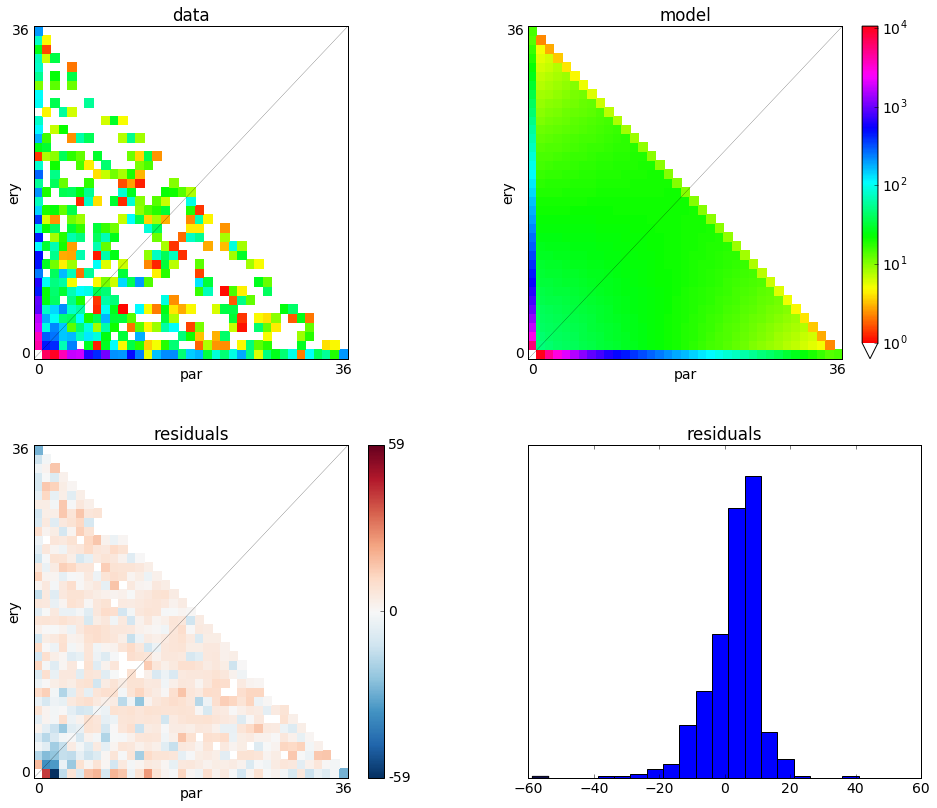

In [79]:
import pylab

pylab.rcParams['figure.figsize'] = [14.0, 12.0]
pylab.rcParams['font.size'] = 14.0

dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d_folded, vmin=1)

A good computer screen is required to see the heatmap of the residuals in full detail.

The residuals show that the best-fit model has a deficit of fixed divergent SNP's as well as of low frequency shared SNP's close to the diagonal.

Maybe the fit can be improved by introducing gene flow.

# divergence with migration model

In [156]:
?dadi.Demographics2D.split_mig

In [24]:
%%px --local

func = dadi.Demographics2D.split_mig

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [25]:
%%px --local

# set up global variables on engines required for run_dadi function call

dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d_folded
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 10 # run a maximum of 10 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_mig" # set file name stub for opt. result files

In [26]:
%%px --local

# set lower and upper bounds to nu1, nu2, T, m
upper_bound = [1e4, 1e4, 2, 10]
lower_bound = [1e-4, 1e-4, 0, 0]

In [84]:
# perturb these parameter values
# nu1, nu2, T, m
p0 = [0.5, 0.5, 0.1, 0.1] 
# split into equal proportions at >200,000 generations ago with 1 migrant individual per 10 generations

#ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [85]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [86]:
%%px

fold = 3 # perturb randomly up to `fold` times 2-fold
maxiter = 100 # run a maximum of 10 iterations

In [87]:
# perturb these parameter values
p0 = [0.5, 0.5, 0.1, 0.1] 
# split into equal proportions at >200,000 generations ago with migrant one individual per 10 generations

#ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [88]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [91]:
# perturb these parameter values
p0 = [0.5, 0.5, 0.1, 0.01] 
# split into equal proportions at >200,000 generations ago with one migrant individual per 100 generations

#ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [92]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [93]:
# optimal parameters for nomig model: (0.636945, 1.229606, 0.290465)

# perturb parameter neutral values
p0 = [0.636945, 1.229606, 0.290465, 0.01] 
# split into equal proportions at >200,000 generations ago with migrant individual per 100 generations

ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [94]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [95]:
import numpy as np

In [97]:
m0 = np.logspace(-3, np.log10(5), base=10, num=20)
m0

array([  1.00000000e-03,   1.56560656e-03,   2.45112389e-03,
         3.83749564e-03,   6.00800835e-03,   9.40617727e-03,
         1.47263728e-02,   2.30557058e-02,   3.60961643e-02,
         5.65123915e-02,   8.84761707e-02,   1.38518873e-01,
         2.16866056e-01,   3.39526920e-01,   5.31565572e-01,
         8.32222546e-01,   1.30293308e+00,   2.03988057e+00,
         3.19365039e+00,   5.00000000e+00])

In [98]:
from itertools import product

In [109]:
p0 = [0.636945, 1.229606, 0.290465]

# do parameter sweep for migration rate
#ar_split_mig_1 = lbview.map(run_dadi, [p0 + [m] for m in m0], block=False, order=False)

In [112]:
ar_split_mig_1.progress

19

In [113]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 20
unknown flag 0


In [116]:
p0 = [0.636945, 1.229606, 0.290465, 1e-6]

#ar_split_mig_1 = lbview.map(run_dadi, [p0], block=False, order=False)

In [117]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 1
unknown flag 0


In [118]:
ar_split_mig_1.get()

[(array([  5.67647408e-01,   8.28132232e+00,   2.79617129e-01,
           7.13792423e-06]),
  (array([  6.37632787e-01,   1.22989019e+00,   2.90446980e-01,
            5.49800562e-07]), 20387.430473918725, 100, 178, 2))]

In [119]:
p0 = [0.636945, 1.229606, 0.290465, 1e-8]

#ar_split_mig_1 = lbview.map(run_dadi, [p0], block=False, order=False)

In [120]:
ar_split_mig_1.get()

[(array([  4.69103735e+00,   6.98005316e+00,   2.34055747e-01,
           4.71573909e-09]),
  (array([  6.36962650e-01,   1.22844256e+00,   2.89937795e-01,
            9.28295473e-21]), 20387.445239922406, 100, 169, 2))]

In [122]:
%%px

maxiter = 500

In [123]:
# nu1, nu2, T, m:
p0 = [0.5, 0.5, 0.1, 1e-4]

ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 20), block=False, order=False)

In [124]:
get_flag_count(ar_split_mig_1, NM=True)

success 18
Maximum number of function evaluations made. 2
Maximum number of iterations reached. 0
unknown flag 0


Apparently, convergence of optimisation requires many more than 100 iterations.

In [125]:
success = [flatten(out)[:9] for out in ar_split_mig_1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m_0,nu1_opt,nu2_opt,T_opt,m_opt,-logL
3,0.837500,2.063526,0.058201,0.000110,0.996572,1.771058,0.928727,2.508888e-01,18574.138486
15,0.208178,2.525835,0.609693,0.000767,0.997653,1.771560,0.931469,2.510613e-01,18574.373801
14,1.009844,1.115355,0.012909,0.000309,0.992355,1.760054,0.901086,2.470464e-01,18574.974381
7,0.409099,0.405881,0.168447,0.000052,0.637198,1.230384,0.290581,6.497219e-08,20387.225419
11,2.175460,0.556770,0.086338,0.000014,0.637198,1.230385,0.290581,1.748376e-20,20387.226053
5,0.265271,0.129476,0.157514,0.000045,0.637196,1.230384,0.290580,2.583554e-12,20387.226053
6,0.085281,0.402881,0.364705,0.000042,0.637198,1.230385,0.290581,3.044384e-18,20387.226053
9,0.115098,0.103779,0.172020,0.000113,0.637162,1.230734,0.290565,4.850122e-15,20387.226666
17,3.731189,0.119188,0.015205,0.000017,0.637549,1.230015,0.290740,9.454649e-15,20387.229881
13,1.308999,0.089865,0.482895,0.000052,0.636599,1.228599,0.290307,4.483462e-10,20387.232239


The first three parameter combinations are much more likely than the remaining ones.

In [126]:
# extract optimal parameter combination

df.sort_values(by='-logL', ascending=True).iloc[0, 4:8]

nu1_opt    0.996572
nu2_opt    1.771058
T_opt      0.928727
m_opt      0.250889
Name: 3, dtype: float64

In [128]:
p0 = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 4:8])

#ar_split_mig_2 = lbview.map(run_dadi, repeat(p0, 20), block=False, order=False)

In [129]:
ar_split_mig_2.progress

19

In [132]:
ar_split_mig_2.elapsed/60

25.53058113333333

In [2]:
import numpy as np
import pandas as pd
from utility_functions import *

In [3]:
import dill, glob

ar_split_mig_2 = []

for filename in glob.glob("OUT_2D_models/split_mig*dill"):
    ar_split_mig_2.append(dill.load(open(filename)))

In [4]:
success = [flatten(out)[:9] for out in ar_split_mig_2 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m_0,nu1_opt,nu2_opt,T_opt,m_opt,-logL
8,2.059032,0.360002,0.682463,0.192790,0.994185,1.766127,0.922632,2.506880e-01,18574.119915
31,0.620927,0.849787,1.980000,1.827165,0.994247,1.766242,0.922690,2.507990e-01,18574.120405
2,2.894370,11.363772,1.980000,0.272765,0.993365,1.764405,0.921871,2.509119e-01,18574.121486
28,0.631049,2.924698,0.247732,0.205392,0.993307,1.765318,0.921817,2.509740e-01,18574.122241
17,0.837500,2.063526,0.058201,0.000110,0.996572,1.771058,0.928727,2.508888e-01,18574.138486
18,5.535163,3.398472,0.309525,0.169667,0.993863,1.767477,0.925657,2.517209e-01,18574.159471
15,0.318463,0.315764,0.587406,1.138654,0.989922,1.761280,0.914716,2.507331e-01,18574.164848
1,0.277233,8.221059,0.976626,0.051974,1.001148,1.776879,0.937823,2.505879e-01,18574.226541
0,5.653430,3.362330,1.980000,0.101259,0.995994,1.769480,0.927834,2.507786e-01,18574.341908
33,0.208178,2.525835,0.609693,0.000767,0.997653,1.771560,0.931469,2.510613e-01,18574.373801


Parameter combinations with neg. log likelihood of 20387 are almost identical to the `split-no-migration` from above. Adding some gene flow improves the likelihood of the model.

In section 6, I have noticed that final parameter combinations from "unsuccessfull" optimisations can have higher likelihood than parameter combinations from successfull optimisations. I am therefore going to load the final parameter combinations from all "unsuccessfull" optimisations from file in order to check whether some have higher likelihood than the ones seen so far.

In [27]:
import dill
from glob import glob

In [28]:
ar_split_mig = []

for filename in glob("OUT_2D_models/split_mig*dill"):
    ar_split_mig.append(dill.load(open(filename)))

In [31]:
# get "unsuccessfull" optimisations
returned = [flatten(out)[:9] for out in ar_split_mig if out[1][4] != 0]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,T_0,m_0,nu1_opt,nu2_opt,T_opt,m_opt,-logL
40,0.810084,1.218102,0.547376,0.247139,0.991729,1.763794,0.920356,0.251048,18574.132734
37,0.489094,1.037535,0.132257,0.000176,0.989262,1.756507,0.914103,0.251147,18574.172032
0,1.494576,6.954689,0.542031,0.010270,0.984775,1.749987,0.906018,0.251081,18574.291695
49,0.299664,0.357796,0.174061,0.291803,0.996390,1.773132,0.929317,0.251732,18574.431565
30,0.500123,0.224216,0.050188,0.236097,0.985358,1.750439,0.909906,0.253170,18574.527262
34,0.688407,2.368404,0.492408,0.024299,1.007132,1.769779,0.941429,0.250509,18574.908052
52,1.014963,0.091473,0.018470,0.165964,1.025306,1.806740,0.963090,0.246319,18575.665086
27,0.258895,1.496689,0.135203,5.109754,1.006629,1.791963,0.942875,0.254426,18576.258223
62,0.240427,1.288769,0.019360,0.063827,0.958215,1.690832,0.868486,0.256389,18577.123050
59,2.097444,2.629962,0.281612,1.580978,1.041270,1.831819,0.981282,0.244224,18577.123802


There are no better parameter combinations than the ones already seen.

In [5]:
df.sort_values(by='-logL', ascending=True).iloc[0, 4:8]

nu1_opt    0.994185
nu2_opt    1.766127
T_opt      0.922632
m_opt      0.250688
Name: 8, dtype: float64

In [6]:
popt = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 4:8])

In [32]:
# calculate best-fit model spectrum

model_spectrum = func_ex(popt, ns, pts_l)

In [33]:
# log likelihood of the observed 2D spectrum given the model

ll_model = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)

In [34]:
ll_model

-18574.119915473293

In [36]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d_folded)
theta

6354.4435616608989

In [1]:
mu = 3e-9
L = sfs2d_folded.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

NameError: name 'sfs2d_folded' is not defined

## plot

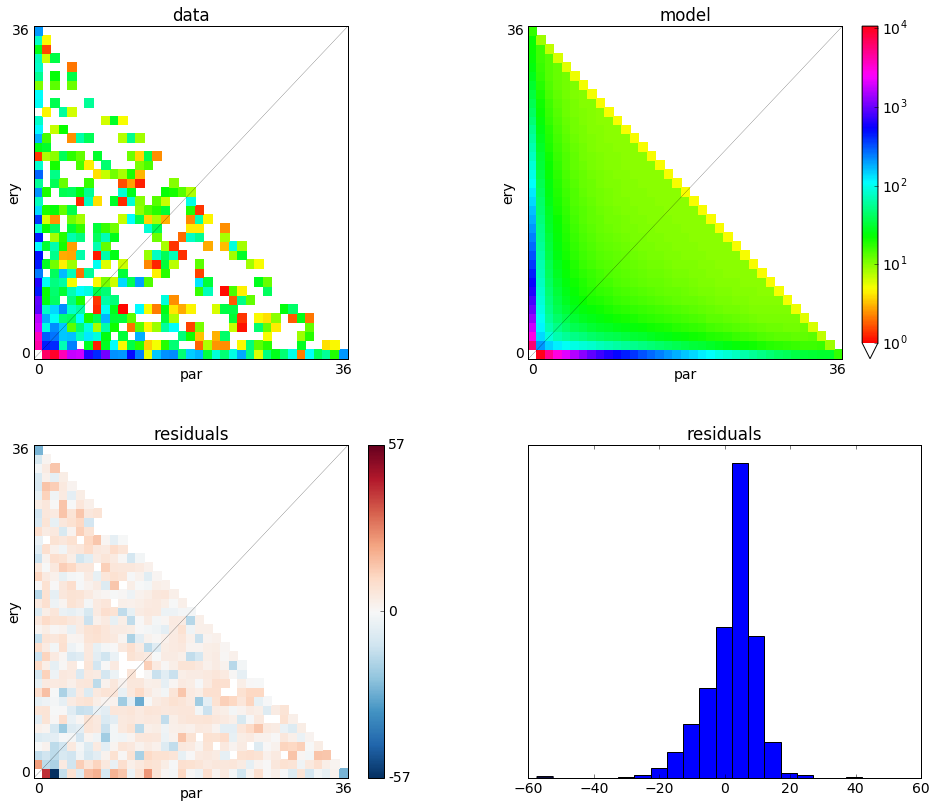

In [145]:
dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d_folded, vmin=1)

This has reduced the residuals for low frequency shared polymorphisms, but the model still cannot fit divergently fixed SNP's well.

## Translation of _m_

The dadi manual says about the migration rate parameter (on page 11):

>The migration parameter m12 specifies the rate of migration from pop 2 into pop 1. It is equal to the _fraction of individuals_ each generation in pop 1 that are new migrants from pop 2, times the 2Nref.

So the fraction of new immigrant alleles each generation from $pop_2$ in $pop_1$ is:
$$
p_{m12} = \frac{m_{12}}{2N_{ref}}
$$

Since dadi's migration rate is scaled by 2Nref, the migration rate parameter as reported by dadi has units of _immigrant alleles per generation_ for a diploid locus. However, whenever pop 1 does not have the same size as the ancestral population ($N_{ref}$}, dadi's $m_{12}$ needs to be rescaled by multiplication with $\nu_1$ to get the number of immigrant alleles per generation ($M_{12}$):

$$
\begin{align}
M_{12} &= p_{m12} \times 2N_{ref}\nu_1 \\[5pt]
M_{12} &= \nu_1 m_{12}
\end{align}
$$


See this [confirm units of dadi](https://groups.google.com/forum/#!searchin/dadi-user/Nref%7Csort:relevance/dadi-user/AY_4NoEjsx8/eamGdb39AwAJ) thread on the dadi forum.

What does this model fit say in plain English:

In [54]:
print "The ancestral population split apart {0:,} generation ago.".format(int(popt[2]*2*N_ref)), 
print "Since then, ery and par had a constant population size of {0:,} and {1:,}, respectively.".format(int(popt[0]*N_ref), int(popt[1]*N_ref)), 
print "Since the split, a fraction of {0:.2e} of the population size each generation were made up of new immigrant individuals from the other subspecies.".format(popt[3]/2/N_ref),
print "Put another way:",
print "Since the split ery received a constant number of {0:.2f} new immigrant alleles per generation, while par received a constant number of {1:.2f} per generation.".format(popt[3]*popt[0], popt[3]*popt[1])

The ancestral population split apart 864,128 generation ago. Since then, ery and par had a constant population size of 465,572 and 827,069, respectively. Since the split, a fraction of 2.68e-07 of the population size each generation were made up of new immigrant individuals from the other subspecies. Put another way: Since the split ery received a constant number of 0.25 new immigrant alleles per generation, while par received a constant number of 0.44 per generation.


## LRT

Is the model *with* migration significantly better than the model *without* migration?

From the dadi manual:

>The full likelihood ratio test statistic is equal to $D = 2(ll_c - ll_s)$ where $ll_c$ and $ll_s$ are the likelihoods of the complex and simple model, respectively.

$D$ should be $\chi^2$ distributed

>with degrees of freedom equal to the difference in number of parameters between the simple and complex model.

Not all SNP's in the spectrum will be unlinked with each other. Therefore, the *likelihoods* calculated are *composite likelihoods*. Dadi can calculate an adjustment factor for $D$ that corrects for linkage. However, this requires bootstrapped data sets, which I haven't created yet. In the following calculation I am assuming that all SNP's can be assumed independent data points.

In [56]:
ll_c = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)
ll_c

-18574.119915473293

In [59]:
func = split_nomig

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

# calculate best-fit model spectrum with optimal parameter values
model_spectrum = func_ex((0.636945, 1.229606, 0.290465), ns, pts_l)

ll_s = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)
ll_s

-20387.227246474409

In [60]:
D = 2*(ll_c - ll_s)
D

3626.2146620022322

From the dadi example script `YRI_CEY.py`:

>Because this is a test of a parameter on the boundary of the parameter space 
(m cannot be less than zero), our null distribution is an even proportion 
of chi^2 distributions with 0 and 1 d.o.f. To evaluate the p-value, we use the
point percent function for a weighted sum of chi^2 dists.

See Self2007 for more complex cases.

In [61]:
# calculate p-value
p = dadi.Godambe.sum_chi2_ppf(D, weights = (0.5, 0.5))
p

0.0

Gene flow significantly improves the fit to the observed spectrum. I doubt that there could be enough linkage in the data to compromise this result.

# Recent secondary contact model

Phylogeographic studies as well as paleoclimatic data strongly suggest that the two subspecies, _erythropus_ and _parallelus_, diverged in isolation during at least the last ice age and only recently (~10,000 YBP) came into secondary contact. Clines of several morphological as well as molecular markers have been shown to be very wide, which indicates substantial gene flow across the hybrid zone into adjacent pure populations. The two population samples come from such "pure" populations in close proximity to the hybrid zone. They may therefore show evidence of _recent_ gene flow between the two subspecies.

In [1]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [2]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

error in importing Two Locus modules


In [3]:
%%px --local

# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

sfs2d = sfs2d_unfolded.fold()

In [4]:
sfs2d.sample_sizes

array([36, 36])

In [5]:
%%px --local

sfs2d.pop_ids = ['ery', 'par']

I am now defining a model function that is a mixture of the `split_nomig` and `split_mig` models. It specifies a split, divergence in isolation for a time $T_i$, then secondary contact of the two diverged populations since $T_c$ times $2N_{ref}$ generations in the past.

In [6]:
def secondary_contact(params, ns, pts):
    """
    params = (nu1,nu2,Ti,Tc,m)
    ns = (n1,n2)

    Split into two populations of specified size, 
    then diverge in isolation,
    finally come into secondary contact.

    nu1: Size of population 1 after split.
    nu2: Size of population 2 after split.
    Ti: Time of divergence in isolation (in units of 2*Na generations)
    Tc: Time in the past when secondary contact began (and continues till present)
    m: symmetrical migration rate (in units of 2*Na per generation)
    
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu1,nu2,Ti,Tc,m = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi) # split

    # divergence in isolation
    phi = dadi.Integration.two_pops(phi, xx, Ti, nu1, nu2, m12=0, m21=0) 
    
    # secondary contact
    phi = dadi.Integration.two_pops(phi, xx, Tc, nu1, nu2, m12=m, m21=m)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

In [7]:
# push model function into namespace of remote engines

cl[:].push(dict(secondary_contact=secondary_contact))

<AsyncResult: _push>

In [18]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [8]:
%%px --local

func = secondary_contact

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

In [20]:
%%px --local

# set up global variables on engines required for run_dadi function call

dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 100 # run a maximum of 100 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/sec_contact" # set file name stub for opt. result files

In [9]:
%%px --local

# set lower and upper bounds to nu1, nu2, Ti, Tc and m
upper_bound = [1e4, 1e4, 5, 5, 10]
lower_bound = [1e-4, 1e-4, 0, 0, 0]

ns = sfs2d.sample_sizes # both populations have the same sample size

# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]

In [13]:
# perturb these parameter values for starting value generation
p0 = [1, 1.5, 0.9, 0.1, 1]
# nu_1, nu_2, Ti, Tc, m

# run locally
run_dadi(p0)

(array([ 0.32912152,  1.74859714,  0.49916884,  0.27947294,  2.53155626]),
 (array([ 0.6746985 ,  1.38442775,  0.36257617,  0.02475325,  0.65765189]),
  19457.799214498067,
  100,
  158,
  2))

The code works in principle. However, the upper optimisation did not converge (flag==2).

In [16]:
lbview = cl.load_balanced_view()

In [17]:
from itertools import repeat

In [18]:
# perturb parameter neutral values
p0 = [ 0.6746985 ,  1.38442775,  0.36257617,  0.02475325,  0.65765189] 
# although the single optimisation above was not successfull (flag==2), 
# I am using its returned values as starting values for perturbation

#ar_sec_contact_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [10]:
from utility_functions import *

In [20]:
get_flag_count(ar_sec_contact_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [22]:
%%px

# increase the maximum number of iterations
maxiter = 300

In [23]:
# perturb parameter neutral values
p0 = [ 0.6746985 ,  1.38442775,  0.36257617,  0.02475325,  0.65765189] 
# although the single optimisation above was not successfull (flag==2), 
# I am using its returned values as starting values for perturbation

#ar_sec_contact_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [33]:
# get total running time in minutes
ar_sec_contact_1.wall_time/60

15.04222375

In [24]:
get_flag_count(ar_sec_contact_1, NM=True)

success 5
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 5
unknown flag 0


5 runs succeeded, 5 hit the maxiter limit.

In [11]:
import pandas as pd

In [36]:
success = [flatten(out)[:11] for out in ar_sec_contact_1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'Ti_0', 'Tc_0', 'm_0', 'nu1_opt', 'nu2_opt', 'Ti_opt', 'Tc_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,Ti_0,Tc_0,m_0,nu1_opt,nu2_opt,Ti_opt,Tc_opt,m_opt,-logL
1,1.736578,0.723766,1.129848,0.030990,0.262542,1.293516,2.273727,0.592114,0.925393,0.228020,18685.067468
4,0.776660,1.097054,1.000994,0.097170,0.263323,1.994819,3.457283,0.997695,2.225043,0.156405,18756.367519
0,1.174580,0.709201,1.369166,0.033279,0.931187,0.624726,1.206711,0.352286,0.071660,0.586254,19359.723909
2,1.839585,0.749805,1.201031,0.075388,1.137171,0.713783,1.378343,0.374022,0.005218,1.922404,19700.609637
3,0.409697,0.454478,0.814574,0.040403,1.043188,0.344442,0.572411,0.710683,4.998493,1.070725,24081.306885


The second parameter combination from the bottom is the closest to a `recent-secondary-contact` model, but it has slightly lower likelihood than models that specify a much longer time of secondary contact ($T_c$).

In [14]:
import numpy as np

In [ ]:
# extract best parameter combination
pset = np.array(df.sort_values(by='-logL', ascending=True).iloc[0,5:10])

In [32]:
# perturb from best parameter combination
p0 = pset

#ar_sec_contact_2 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [34]:
get_flag_count(ar_sec_contact_2, NM=True)

success 3
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 7
unknown flag 0


Only 3 runs succeeded.

In [37]:
# add output from successfull runs to table

success.extend([flatten(out)[:11] for out in ar_sec_contact_2 if out[1][4] == 0])

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'Ti_0', 'Tc_0', 'm_0', 'nu1_opt', 'nu2_opt', 'Ti_opt', 'Tc_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,Ti_0,Tc_0,m_0,nu1_opt,nu2_opt,Ti_opt,Tc_opt,m_opt,-logL
7,1.236540,2.847184,0.230733,3.068632,0.849626,0.995633,1.767191,0.089521,0.836080,0.251181,18574.175975
5,1.006920,2.471800,0.560705,1.489177,0.540249,1.007125,1.785494,0.144681,0.789880,0.249414,18574.820474
6,4.600362,4.057741,0.163307,1.080377,0.070965,1.128504,1.983990,0.054273,1.143632,0.239594,18596.261482
1,1.736578,0.723766,1.129848,0.030990,0.262542,1.293516,2.273727,0.592114,0.925393,0.228020,18685.067468
4,0.776660,1.097054,1.000994,0.097170,0.263323,1.994819,3.457283,0.997695,2.225043,0.156405,18756.367519
0,1.174580,0.709201,1.369166,0.033279,0.931187,0.624726,1.206711,0.352286,0.071660,0.586254,19359.723909
2,1.839585,0.749805,1.201031,0.075388,1.137171,0.713783,1.378343,0.374022,0.005218,1.922404,19700.609637
3,0.409697,0.454478,0.814574,0.040403,1.043188,0.344442,0.572411,0.710683,4.998493,1.070725,24081.306885


The most likely parameter combination has the same likelihood as the best-fit for the `split_mig` model (i. e. the model with $T_i = 0$). The best-fit parameters for this secondary contact model suggest only a short time of complete isolation followed by a long time of secondary contact, which is qualitatively equivalent to a model without complete isolation. A $T_i$ greater 0 does not improve the likelihood, so I think it is not significant.

In section 6, I have noticed that final parameter combinations from "unsuccessfull" optimisations can have higher likelihood than parameter combinations from successfull optimisations. I am therefore going to load the final parameter combinations from all "unsuccessfull" optimisations from file in order to check whether some have higher likelihood than the ones seen so far.

In [ ]:
from glob import glob
import dill

In [32]:
ar_sec_contact = []

for filename in glob("OUT_2D_models/sec_contact*dill"):
    ar_sec_contact.append(dill.load(open(filename)))

In [33]:
# get parameters from "successfull" runs into a table

returned = ([flatten(out)[:11] for out in ar_sec_contact if out[1][4] != 0])

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Ti_0', 'Tc_0', 'm_0', 'nu1_opt', 'nu2_opt', 'Ti_opt', 'Tc_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,Ti_0,Tc_0,m_0,nu1_opt,nu2_opt,Ti_opt,Tc_opt,m_opt,-logL
7,2.291806,0.941107,0.417754,0.701156,0.280979,0.995790,1.768780,4.236017e-09,0.928104,0.250866,18574.136842
5,1.153465,2.238480,0.164853,0.034364,1.314128,0.989694,1.757785,1.310731e-01,0.779922,0.251502,18574.445432
16,0.390701,1.897315,0.759622,0.446801,0.700774,0.994296,1.771438,1.354936e-01,0.779559,0.250514,18574.532394
17,0.228105,5.126482,0.093396,0.087684,0.331095,1.005337,1.778832,1.211617e-03,0.932793,0.246241,18574.947916
19,0.402956,1.380227,0.550776,2.572429,0.157063,0.987372,1.754340,1.760467e-01,0.726734,0.252789,18575.195890
27,1.127186,4.079809,0.302806,0.931041,0.188286,1.002210,1.779032,3.747498e-02,0.918896,0.254661,18575.351564
21,0.591352,3.382051,0.243697,0.081228,0.530071,1.027357,1.796094,3.927616e-02,0.932124,0.249578,18576.313944
9,0.641737,0.514314,1.387458,0.177460,0.792364,0.984155,1.754487,2.447613e-01,0.641696,0.252011,18578.754324
20,1.410039,1.372531,0.330353,0.013720,0.307076,1.019769,1.806807,2.922993e-01,0.643927,0.253146,18583.452364
4,2.905423,0.631460,0.214681,0.640778,0.695418,1.082403,1.921692,9.934621e-02,1.046310,0.253279,18594.697610


There are no better no better parameter combinations than seen so far. But notice that this table shows that a $T_i$ that is practically 0 (top row) does not lower likelihood.

Let's search in the parameter space that is closer to a isolation with recent secondary contact model.

In [40]:
p0 = [0.624726, 1.206711, 0.352286, 0.071660, 0.586254]

#ar_sec_contact_3 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [41]:
get_flag_count(ar_sec_contact_3, NM=True)

success 2
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 8
unknown flag 0


In [42]:
# add output from successfull runs to table

success.extend([flatten(out)[:11] for out in ar_sec_contact_3 if out[1][4] == 0])

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'Ti_0', 'Tc_0', 'm_0', 'nu1_opt', 'nu2_opt', 'Ti_opt', 'Tc_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,Ti_0,Tc_0,m_0,nu1_opt,nu2_opt,Ti_opt,Tc_opt,m_opt,-logL
8,0.800833,1.775923,0.481231,0.034021,0.318631,0.993736,1.766119,0.066064,0.854641,0.250961,18574.115189
7,1.236540,2.847184,0.230733,3.068632,0.849626,0.995633,1.767191,0.089521,0.836080,0.251181,18574.175975
5,1.006920,2.471800,0.560705,1.489177,0.540249,1.007125,1.785494,0.144681,0.789880,0.249414,18574.820474
6,4.600362,4.057741,0.163307,1.080377,0.070965,1.128504,1.983990,0.054273,1.143632,0.239594,18596.261482
1,1.736578,0.723766,1.129848,0.030990,0.262542,1.293516,2.273727,0.592114,0.925393,0.228020,18685.067468
4,0.776660,1.097054,1.000994,0.097170,0.263323,1.994819,3.457283,0.997695,2.225043,0.156405,18756.367519
0,1.174580,0.709201,1.369166,0.033279,0.931187,0.624726,1.206711,0.352286,0.071660,0.586254,19359.723909
2,1.839585,0.749805,1.201031,0.075388,1.137171,0.713783,1.378343,0.374022,0.005218,1.922404,19700.609637
9,0.268733,0.753785,0.812007,0.023443,1.451094,0.678586,1.296590,0.350150,0.004832,1.924542,19711.069713
3,0.409697,0.454478,0.814574,0.040403,1.043188,0.344442,0.572411,0.710683,4.998493,1.070725,24081.306885


The best-fit parameters clearly do not describe a long time of divergence in isolation followed by recent high gene flow. In contrast, they generally indicate a long period of secondary contact with a migration rate that is essentially the same as the one estimated for the simple divergence with (uninterrupted) migration model above.

The secondary contact model with best-fit parameters has the same likelihood as the simple isolation with constant migration model above. This indicates that the time of isolation $T_i$ is not significantly different from 0.

In [12]:
# reload data from files into data frame

from glob import glob
import dill
from utility_functions import *
import pandas as pd
import numpy as np

ar_sec_contact = []

for file in glob('OUT_2D_models/sec_contact*dill'):
    ar_sec_contact.append(dill.load(open(file)))
    
success = [flatten(out)[:11] for out in ar_sec_contact if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'Ti_0', 'Tc_0', 'm_0', 'nu1_opt', 'nu2_opt', 'Ti_opt', 'Tc_opt', 'm_opt', '-logL'])

In [13]:
popt = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 5:10])
popt

array([ 0.99373584,  1.76611873,  0.06606356,  0.8546411 ,  0.25096087])

In [14]:
# determine theta

# get the unscaled optimal secondary contact model spectrum
model_spectrum = func_ex(popt, ns, pts_l)

# get theta
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum.fold(), sfs2d)

theta

6357.6920380892325

Note, this is a much lower theta than the one implied by the simple isolation model above (section 1).

## plot residuals

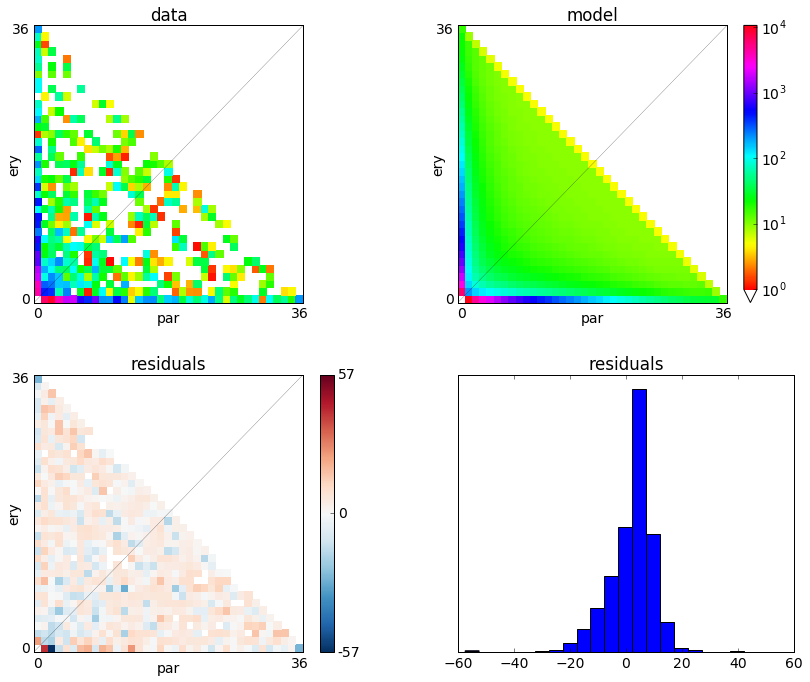

In [58]:
import pylab

%matplotlib inline

pylab.rcParams['figure.figsize'] = [12, 10]
pylab.rcParams['font.size'] = 14

dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d, vmin=1)

The best-fit SC model spectrum looks very similar to the best-fit IM model (see previous section).

In [31]:
mu = 3e-9
L = sfs2d.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population Nref of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

The total sequence length for the 2D spectrum is 1,130,775.
The effective size of the ancestral population Nref of ery and par (in number of diploid individuals) implied by this theta is: 468,535.


The best-fit parameters of this model say the following:

In [32]:
print "After the split of the ancestral population {0:,} generations ago, the daughter populations increased in size (instantaneously).".format(int((popt[2]+popt[3])*2*N_ref)),
print "ERY increased to about the same size as the ancestral population (Nref), while PAR increased to {0:.2f} times of Nref.".format(popt[1]),
print "After the split ERY and PAR diverged in isolation for {0:,} generations.".format(int(popt[2]*2*N_ref)),
print "The two populations came into secondary contact {0:,} generations ago.".format(int(popt[3]*2*N_ref)),
print "ERY and PAR stayed in continuous secondary contact until the present and",
print "during that time exchanged one individual from par to ery every {0:.1f} generations".format(1.0/(popt[4]/2*popt[0])),
print "and one individual from ery into par every {0:.1f} generations.".format(1.0/(popt[4]/2*popt[1]))

After the split of the ancestral population 862,764 generations ago, the daughter populations increased in size (instantaneously). ERY increased to about the same size as the ancestral population (Nref), while PAR increased to 1.77 times of Nref. After the split ERY and PAR diverged in isolation for 61,906 generations. The two populations came into secondary contact 800,858 generations ago. ERY and PAR stayed in continuous secondary contact until the present and during that time exchanged one individual from par to ery every 8.0 generations and one individual from ery into par every 4.5 generations.


Parameter combinations that specify a recent secondary contact model, see rows with index 0, 2 and 9 in upper table, have lower likelihood than parameter combinations that are almost identical to an IM model with constant migration.

How does a recent secondary contact (RSC) model spectrum compare with the data?

In [15]:
df.sort_values(by='Tc_opt', ascending=True)

,nu1_0,nu2_0,Ti_0,Tc_0,m_0,nu1_opt,nu2_opt,Ti_opt,Tc_opt,m_opt,-logL
6,0.268733,0.753785,0.812007,0.023443,1.451094,0.678586,1.296590,0.350150,0.004832,1.924542,19711.069713
9,1.839585,0.749805,1.201031,0.075388,1.137171,0.713783,1.378343,0.374022,0.005218,1.922404,19700.609637
2,1.174580,0.709201,1.369166,0.033279,0.931187,0.624726,1.206711,0.352286,0.071660,0.586254,19359.723909
1,1.006920,2.471800,0.560705,1.489177,0.540249,1.007125,1.785494,0.144681,0.789880,0.249414,18574.820474
0,1.236540,2.847184,0.230733,3.068632,0.849626,0.995633,1.767191,0.089521,0.836080,0.251181,18574.175975
5,0.800833,1.775923,0.481231,0.034021,0.318631,0.993736,1.766119,0.066064,0.854641,0.250961,18574.115189
7,1.736578,0.723766,1.129848,0.030990,0.262542,1.293516,2.273727,0.592114,0.925393,0.228020,18685.067468
3,4.600362,4.057741,0.163307,1.080377,0.070965,1.128504,1.983990,0.054273,1.143632,0.239594,18596.261482
8,0.776660,1.097054,1.000994,0.097170,0.263323,1.994819,3.457283,0.997695,2.225043,0.156405,18756.367519
4,0.409697,0.454478,0.814574,0.040403,1.043188,0.344442,0.572411,0.710683,4.998493,1.070725,24081.306885


In [16]:
# extract parameter combination that specifies a secondary contact model

p_sec_contact = np.array(df.sort_values(by='Tc_opt', ascending=True).iloc[0,5:10])
p_sec_contact

array([ 0.67858642,  1.29659005,  0.35015044,  0.00483189,  1.92454244])

This RSC parameter combination says the following:

In [88]:
print "After the split of the ancestral population {0:,} generations ago, the daughter populations increased in size (instantaneously).".format(int((p_sec_contact[2]+p_sec_contact[3])*2*N_ref)),
print "ERY decreased to about {0:.2f} the size of the ancestral population (Nref), while PAR increased to {1:.2f} times of Nref.".format(p_sec_contact[0],p_sec_contact[1]),
print "After the split ERY and PAR diverged in isolation for {0:,} generations.".format(int(p_sec_contact[2]*2*N_ref)),
print "The two populations came into secondary contact {0:,} generations ago.".format(int(p_sec_contact[3]*2*N_ref)),
print "ERY and PAR stayed in continuous secondary contact until present and",
print "during that time contained a proportion {0:.2e} new immigrant alleles each generations.".format(p_sec_contact[4]/2/N_ref)

After the split of the ancestral population 332,643 generations ago, the daughter populations increased in size (instantaneously). ERY decreased to about 0.68 the size of the ancestral population (Nref), while PAR increased to 1.30 times of Nref. After the split ERY and PAR diverged in isolation for 328,115 generations. The two populations came into secondary contact 4,527 generations ago. ERY and PAR stayed in continuous secondary contact until present and during that time contained a proportion 2.05e-06 new immigrant alleles each generations.


In [17]:
# get the optimally scaled secondary contact model spectrum

SC_model_spectrum = dadi.Inference.optimally_scaled_sfs(func_ex(p_sec_contact, ns, pts_l), sfs2d)

In [18]:
%matplotlib inline

import pylab

pylab.rcParams['figure.figsize'] = [12, 10]
pylab.rcParams['font.size'] = 14

In [98]:
%psource dadi.Plotting.plot_2d_comp_Poisson

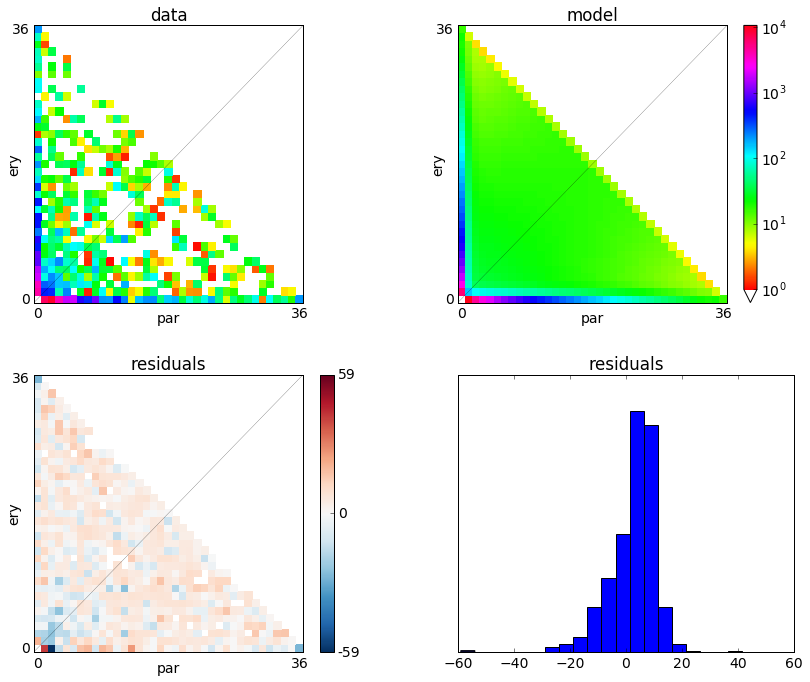

In [23]:
# compare SC model with data

dadi.Plotting.plot_2d_comp_multinom(model=SC_model_spectrum, data=sfs2d, vmin=1)

The recent secondary contact model (RSC) predicts mostly very low frequency introgressed polymorphisms (MAF class 1), but shows a deficit (with respect to the data) of low frequency variants further along the diagonal.

## Compare best fit IM with RSC model spectrum

First, I need to get the best fit IM model spectrum again:

In [19]:
import dill, glob

ar_split_mig_2 = []

for filename in glob.glob("OUT_2D_models/split_mig*dill"):
    ar_split_mig_2.append(dill.load(open(filename)))

In [20]:
success = [flatten(out)[:9] for out in ar_split_mig_2 if out[1][4] == 0]

df_IM = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm_opt', '-logL'])

In [21]:
# get optimal parameter combination for IM model

IM_popt = np.array(df_IM.sort_values(by='-logL', ascending=True).iloc[0, 4:8])
IM_popt

array([ 0.99418511,  1.76612674,  0.92263183,  0.25068798])

In [22]:
# get IM model function (built-in)

IM = dadi.Demographics2D.split_mig

IM_func_ex = dadi.Numerics.make_extrap_log_func(IM)

The best fit IM model spectrum can be extracted with the following code:

In [23]:
IM_model_spectrum = dadi.Inference.optimally_scaled_sfs(IM_func_ex(IM_popt, ns, pts_l).fold(), sfs2d)

In [4]:
%psource dadi.Plotting.plot_2d_comp_multinom

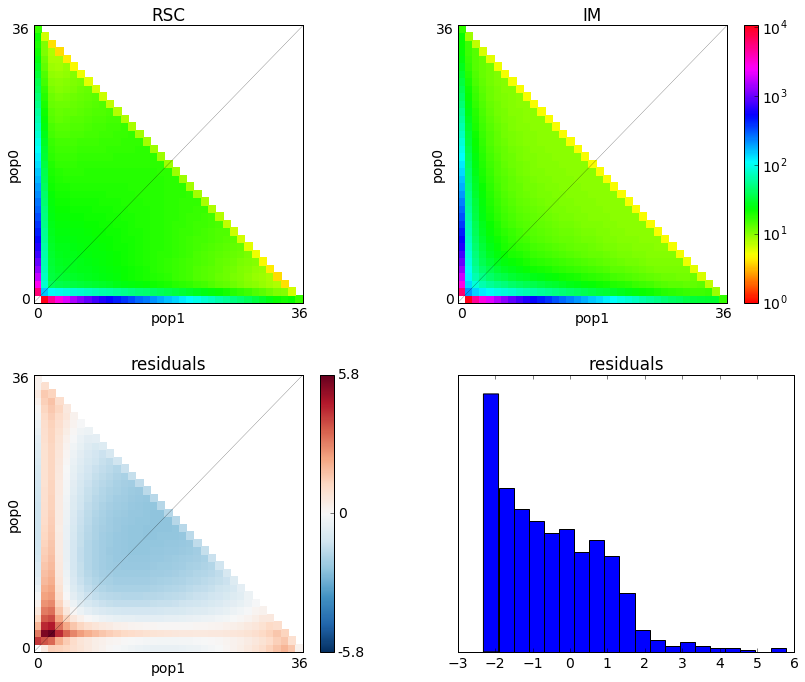

In [24]:
# I have edited the functions `dadi.Plotting.plot_2d_comp_multinom` and `dadi.Plotting.plot_2d_comp_Poisson`
# in `Plotting.py` in the dadi repo to add the argument `title`
dadi.Plotting.plot_2d_comp_multinom(model=IM_model_spectrum, data=SC_model_spectrum.fold(), vmin=1, title=['RSC', 'IM'])

Compared to the IM model, the RSC model predicts many fewer low frequency shared polymorphisms as well as highly diverged polymorphisms (red in the residual plot). On the other hand, recent secondary contact predicts more high frequency shared polymorphisms than isolation with continuous migration (blue in the residual plot).

In [25]:
ll_s = dadi.Inference.ll_multinom(IM_model_spectrum, sfs2d)
ll_s

-18574.1199154733

In [26]:
ll_c = dadi.Inference.ll_multinom(SC_model_spectrum.fold(), sfs2d)
ll_c

-19711.069713468194

The simpler IM model has higher likelihood.

In [27]:
D = 2*(ll_c - ll_s)
D

-2273.8995959897875

In [28]:
# calculate p-value for Chi-square dist. with 1 degree of freedom
p = dadi.Godambe.sum_chi2_ppf(D, weights=(0.5, 0.5))
p

1.0

This is like testing whether $T_i$ is significantly different from 0 (it is 0 in the IM model).

It looks like the simpler IM model is _significantly_ better than the more complex RSC model, but I don't know how to test that. That is I would like to know how confident I can be that the true $T_i$ == 0. In a Bayesian framework I could check whether the 95% CI of the posterior distribution for $T_i$ falls into a (arbitrarily sized) region of practical equivalence (ROPE) with 0. An ABC analysis might be necessary to answer this question statistically. I think what can be said with very high confidence is that $T_i$ cannot be as large as $0.9 \times 2N_{ref}$ as in this parameterisation as this lowers the probability of the data by 1,136 log-likelihood units compared to a $T_i$ of 0.

In [33]:
0.92263183 * 2*N_ref

864570.6174471986

In [34]:
ll_s - ll_c

1136.9497979948937

I doubt that it could it be as simple as:

In [73]:
dadi.Godambe.sum_chi2_ppf(2*(ll_s - ll_c))

0.0

# different migration rates for each direction

In [37]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [38]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

In [39]:
%%px --local

# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

In [40]:
%%px --local

# add population labels
sfs2d_unfolded.pop_ids = ["ery", "par"]

sfs2d = sfs2d_unfolded.fold()

In [41]:
%psource dadi.Demographics2D.split_mig

Define an IM model that allows for unequal migration rates between the two populations.

In [58]:
def split_asym_mig(params, ns, pts):
    """
    params = (nu1,nu2,T,m1,m2)
    ns = (n1,n2)

    Split into two populations of specifed size, with potentially asymmetric migration.

    nu1: Size of population 1 after split.
    nu2: Size of population 2 after split.
    T: Time in the past of split (in units of 2*Na generations) 
    m1: Migration rate from ery into par (in units of 2*Na ind per generation)
    m2: Migration rate from par into ery (in units of 2*Na ind per generation)
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu1,nu2,T,m1,m2 = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    
    # split
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi) 
    
    # divergence with potentially asymmetric migration
    phi = dadi.Integration.two_pops(phi, xx, T, nu1, nu2, m12=m2, m21=m1)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

In [43]:
cl[:].push(dict(split_asym_mig=split_asym_mig))

<AsyncResult: _push>

In [44]:
%%px --local

func = split_asym_mig

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [45]:
%%px --local

# set up global variables on engines required for run_dadi function call

ns = sfs2d.sample_sizes # both populations have the same sample size
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]
dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 300 # run a maximum of 300 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_asym_mig" # set file name stub for opt. result files

In [61]:
dadi.Inference.optimize_log_fmin?

In [47]:
from utility_functions import *

---

BEGIN ignore

Ignore this section. Unsuccessfully trying to use `run_dadi` defined in `utility_functions` module.

From the Python Tutorial:

> The global namespace for a module is created when the module definition is read in

and

>  The statements executed by the top-level invocation of the interpreter, either read from a script file or interactively, are considered part of a module called \_\_main\_\_, so they have their own global namespace.

So, my module `utility_functions` has its own global namespace, different from the global namespace of this IPython session. I have there added the line `from __main__ import *` before the definition of the function `run_dadi` in the module `utility_functions`, so that it can see the global namespace if this IPython session.

In [11]:
# perturb these parameter values
# nu1, nu2, T, m1, m2
p0 = [1.0, 1.766, 0.922, 0.25, 0.25] 

# run one optimisation locally
run_dadi(p0)

(array([ 1.93002308,  2.12950808,  0.36138972,  0.49458589,  0.24351897]),
 (array([ 1.16826555,  2.89820108,  1.96146766,  0.06817234,  0.40888606]),
  18126.331780591565,
  171,
  321,
  0))

It works locally.

In [48]:
from itertools import repeat

In [49]:
lbview = cl.load_balanced_view()

In [50]:
%%px --local

# set lower and upper bounds to nu1, nu2, T, m1, m2
upper_bound = [1e4, 1e4, 4, 10, 10] # note, I have increased the upper bound for T
lower_bound = [1e-4, 1e-4, 0, 0, 0]

In [21]:
# using optimal parameters from simple divergence with migration model (split_mig)
p0 = [1.0, 1.766, 0.922, 0.25, 0.25] 

ar_split_asym_mig_1 = lbview.map(run_dadi, repeat(p0, 1), block=False, order=True)

In [22]:
ar_split_asym_mig_1.get()

CompositeError: one or more exceptions from call to method: run_dadi
[15:apply]: NameError: global name 'perturb' is not defined

END ignore.

---

In [60]:
dadi.Misc.perturb_params?

In [53]:
%%px --local

# set lower and upper bounds to nu1, nu2, T, m1, m2
upper_bound = [1e4, 1e4, 4, 10, 10] # note, I have increased the upper bound for T
lower_bound = [1e-4, 1e-4, 0, 0, 0]

In [54]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [58]:
from itertools import repeat

In [56]:
lbview = cl.load_balanced_view()

In [57]:
# using optimal parameters from simple divergence with migration model (split_mig)
p0 = [1.0, 1.766, 0.922, 0.25, 0.25] 

In [15]:
#ar_split_asym_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [28]:
get_flag_count(ar_split_asym_mig_1, NM=True)

success 3
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 7
unknown flag 0


In [10]:
import dill
from glob import glob

In [11]:
ar_split_asym_mig = []

for filename in glob("OUT_2D_models/split_asym_mig*dill"):
    ar_split_asym_mig.append(dill.load(open(filename)))

In [12]:
import pandas as pd

In [15]:
l = 2*len(p0)+1

success = [flatten(out)[:l] for out in ar_split_asym_mig if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m1_0,m2_0,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
16,0.782220,1.448548,4.639001,0.072158,0.638342,0.920911,2.238617,1.244681,0.084147,0.494918,18104.966267
0,0.661003,7.163811,1.265469,0.257890,0.190122,0.920526,2.236116,1.241691,0.084361,0.494500,18104.971893
2,0.303698,1.230424,0.319167,0.222183,0.228972,0.922813,2.243404,1.254244,0.083942,0.494334,18104.983699
1,0.287213,1.386083,0.493232,0.096763,0.103789,0.915567,2.223840,1.228988,0.084270,0.497170,18105.001298
10,0.234347,0.568305,0.310253,0.112591,0.538129,0.912096,2.209951,1.210935,0.084060,0.497975,18105.141289
14,0.445903,1.955658,2.155467,0.025188,0.607712,0.928113,2.253559,1.279568,0.084935,0.493929,18105.232355
12,0.840609,1.431975,0.454631,0.032701,0.460575,0.933747,2.248026,1.278518,0.086974,0.490424,18105.547423
19,0.318476,1.235161,0.915553,0.202189,0.451816,0.889937,2.161759,1.149623,0.084294,0.506266,18106.119019
11,0.690318,5.005598,4.836252,0.090996,0.826606,0.863008,2.164950,1.144191,0.081105,0.540134,18111.340526
13,0.938970,5.369017,0.555250,0.035365,0.192065,0.802773,2.001577,0.992511,0.080623,0.556180,18121.001018


These 4 optimisations consistently indicate a much smaller gene flow from _erythropus_ into _parallelus_ than in the other direction. This seems plausible when considering the observed expansion of the range of parallelus towards the south of the Pyrenees. Shapes of neutral clines across the hybrid zone should also be less steep on the _erythropus_ side than on the _parallelus_ side.

In [35]:
%%px --local

maxiter = 500

In [36]:
cl[1]['fold']

2

In [37]:
upper_bound

[10000.0, 10000.0, 4, 10, 10]

I will need to increase the upper bound on the divergence time $T$. Otherwise, perturbation can result in starting values above the upper bound.

In [38]:
%%px --local

upper_bound = [10000.0, 10000.0, 6, 10, 10]

In [39]:
# using previous optimal parameters as starting values to perturb
p0 = [0.915567, 2.223840, 1.228988, 0.084270, 0.497170] 

ar_split_asym_mig_2 = lbview.map(run_dadi, repeat(p0, 20), block=False, order=True)

In [15]:
ar_split_asym_mig = []

for filename in glob("OUT_2D_models/split_asym_mig*dill"):
    ar_split_asym_mig.append(dill.load(open(filename)))
    
l = 2*len(p0)+1

success = [flatten(out)[:l] for out in ar_split_asym_mig if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m1_0,m2_0,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
16,0.782220,1.448548,4.639001,0.072158,0.638342,0.920911,2.238617,1.244681,0.084147,0.494918,18104.966267
0,0.661003,7.163811,1.265469,0.257890,0.190122,0.920526,2.236116,1.241691,0.084361,0.494500,18104.971893
2,0.303698,1.230424,0.319167,0.222183,0.228972,0.922813,2.243404,1.254244,0.083942,0.494334,18104.983699
1,0.287213,1.386083,0.493232,0.096763,0.103789,0.915567,2.223840,1.228988,0.084270,0.497170,18105.001298
10,0.234347,0.568305,0.310253,0.112591,0.538129,0.912096,2.209951,1.210935,0.084060,0.497975,18105.141289
14,0.445903,1.955658,2.155467,0.025188,0.607712,0.928113,2.253559,1.279568,0.084935,0.493929,18105.232355
12,0.840609,1.431975,0.454631,0.032701,0.460575,0.933747,2.248026,1.278518,0.086974,0.490424,18105.547423
19,0.318476,1.235161,0.915553,0.202189,0.451816,0.889937,2.161759,1.149623,0.084294,0.506266,18106.119019
11,0.690318,5.005598,4.836252,0.090996,0.826606,0.863008,2.164950,1.144191,0.081105,0.540134,18111.340526
13,0.938970,5.369017,0.555250,0.035365,0.192065,0.802773,2.001577,0.992511,0.080623,0.556180,18121.001018


There is good convergence of parameter estimates.

In section 6, I have noticed that final parameter combinations from "unsuccessfull" optimisations can have higher likelihood than parameter combinations from successfull optimisations. I am therefore going to load the final parameter combinations from all "unsuccessfull" optimisations from file in order to check whether some have higher likelihood than the ones seen so far.

In [35]:
from glob import glob
import dill

In [37]:
ar_split_asym_mig = []

for filename in glob("OUT_2D_models/split_asym_mig_[1234567890]*dill"):
    ar_split_asym_mig.append(dill.load(open(filename)))
    
l = 2*5+1

# get parameters from "unsuccessfull" optimisations
returned = [flatten(out)[:l] for out in ar_split_asym_mig if out[1][4] != 0]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,T_0,m1_0,m2_0,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
1,0.690910,1.962277,0.655486,0.716114,0.081910,0.929836,2.267261,1.289605,0.085435,0.493187,18105.358461
10,0.474111,0.694113,1.372862,0.274980,0.360411,0.915513,2.217017,1.244177,0.087882,0.492707,18105.676702
2,0.374716,0.762272,0.893552,0.102632,0.794584,0.821036,2.008494,0.953877,0.081085,0.535729,18121.484292
4,0.508079,1.207476,1.435114,0.198507,0.616905,0.822370,1.938384,0.927379,0.087170,0.520851,18125.149235
3,2.769222,0.647108,1.353683,0.115349,0.255028,1.091256,2.748012,1.889591,0.068154,0.450564,18125.300712
6,2.762117,1.263134,0.827294,0.321558,0.722256,0.827753,1.938023,0.910884,0.094737,0.499529,18129.919009
0,0.851793,4.949280,0.377467,0.114910,0.249700,0.743511,1.889542,0.880640,0.075930,0.593904,18148.593880
7,0.479148,2.697403,1.308368,0.063333,0.771626,0.726636,1.853824,0.862483,0.055201,0.679454,18195.974398
5,3.615531,1.620456,0.242806,0.071169,0.388806,0.899524,2.471708,1.095278,0.018243,0.521348,18305.658175
8,2.236108,0.586673,0.475731,0.151910,0.125131,0.723413,1.961768,0.792235,0.000248,0.658915,18339.654185


No better parameter combinations than seen before can be found here.

## plain English

In [16]:
import numpy as np

In [17]:
popt = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 5:10])
popt

array([ 0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818])

In [18]:
func = split_asym_mig

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [22]:
# calculate best-fit model spectrum

model_spectrum = func_ex(popt, ns, pts_l)

model_spectrum_asym_mig_scaled = dadi.Inference.optimally_scaled_sfs(model_spectrum, sfs2d)

In [23]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d)

In [24]:
print "The optimal value of theta for the ancestral population is {0:4d}.".format(int(theta))

The optimal value of theta for the ancestral population is 5572.


In [25]:
mu = 3e-9
L = sfs2d.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

The total sequence length for the 2D spectrum is 1,130,775.
The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: 410,678.


In [29]:
print "The ancestral population split apart {0:,} generations ago.".format(int(popt[2]*2*N_ref)),
print "Immediately after the split the ERY population changed to a size of {0:.2f} times Nref and the PAR population to {1:.2f} times Nref.".format(popt[0], popt[1]),
print "Since the split of the ancestral population, PAR received 1 individual from ERY every {0:.2f} generations,".format(1.0/(popt[3]/2*popt[1])),
print "while ERY received 1 PAR individual every {0:.2f} generations.".format(1.0/(popt[4]/2*popt[0])),
print "Put another way: The par population contained a constant proportion of {0:.2e} of new immigrant alleles each generation".format(popt[3]/2/N_ref),
print "and the ery population contained a constant proportion of {0:.2e} of new immigrant alleles each generation.".format(popt[4]/2/N_ref)

The ancestral population split apart 1,022,329 generations ago. Immediately after the split the ERY population changed to a size of 0.92 times Nref and the PAR population to 2.24 times Nref. Since the split of the ancestral population, PAR received 1 individual from ERY every 10.62 generations, while ERY received 1 PAR individual every 4.39 generations. Put another way: The par population contained a constant proportion of 1.02e-07 of new immigrant alleles each generation and the ery population contained a constant proportion of 6.03e-07 of new immigrant alleles each generation.


This model therefore indicates a much stronger introgression from _parallelus_ into _erythropus_ than in the opposite direction. Is the asymmetrical gene flow significant?

## LRT

In [30]:
ll_c = dadi.Inference.ll_multinom(model_spectrum, sfs2d)
ll_c

-18104.966266885222

In [31]:
# get maximum log likelihood of best fit parameter combination for the model
# with symmetrical migration rates

func = dadi.Demographics2D.split_mig

func_ex = dadi.Numerics.make_extrap_log_func(func)

# best-fit paramter combination for the split_mig model (see section 2 above)
popt_split_mig = [0.994185, 1.766127, 0.922632, 0.250688]

model_spectrum_sym_mig = func_ex(popt_split_mig, ns, pts_l)

model_spectrum_sym_mig_scaled = dadi.Inference.optimally_scaled_sfs(model_spectrum_sym_mig, sfs2d)

ll_s = dadi.Inference.ll_multinom(model_spectrum_sym_mig, sfs2d)
ll_s

-18574.11991248127

In [32]:
D = 2*(ll_c - ll_s)
D

938.30729119209718

In [77]:
# calculate p-value for Chi-square dist. with 1 degree of freedom
p = dadi.Godambe.sum_chi2_ppf(D)
p

0.0

It looks as though allowing for asymmetrical gene flow significantly improves the fit to the data. Linkage is unlikely to push the p-value above a significance value of 1e-2, for instance.

## Is the migration rate from ery into par (_m1_) statistically significant?

In [63]:
%%px --local

# set up global variables on engines required for run_dadi function call

ns = sfs2d.sample_sizes # both populations have the same sample size
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]
dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 300 # run a maximum of 300 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_asym_mig_nom1" # set file name stub for opt. result files
# fix m1 to zero, allow all other parameters to be optimised:
fixed_params = [None, None, None, 0.0, None] # specify None to optimise all params

In [70]:
dadi.Inference.optimize_log_fmin?

In [62]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output, \
                                 fixed_params=fixed_params)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [69]:
# using optimal parameters as starting values to perturb
# m1 (0.084) will be ignored
p0 = popt 
p0

array([ 0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818])

In [66]:
#ar_split_asym_mig_nom1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [67]:
ar_split_asym_mig_nom1 = []

for filename in glob("OUT_2D_models/split_asym_mig_nom1*dill"):
    ar_split_asym_mig_nom1.append(dill.load(open(filename)))

In [71]:
l = 2*len(p0)+1

success = [flatten(out)[:l] for out in ar_split_asym_mig_nom1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m1_0,m2_0,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
3,0.604286,1.689639,1.086538,0.048727,0.585935,0.720082,1.962785,0.791503,0.0,0.664581,18340.935861
6,1.197798,1.060943,0.387950,0.070337,0.177612,0.718508,1.960294,0.788789,0.0,0.664332,18340.951096
4,0.588394,3.336045,2.176182,0.035238,0.433038,0.721147,1.961776,0.791353,0.0,0.664706,18340.964537
2,0.400697,4.483709,0.486604,0.282474,0.612249,0.721305,1.961497,0.790718,0.0,0.663976,18340.965653
1,0.250388,0.933745,0.381047,0.123940,1.702059,0.717236,1.953896,0.786673,0.0,0.667389,18340.972028
7,1.163790,2.959924,0.753380,0.124571,0.155288,0.719228,1.967604,0.794908,0.0,0.669281,18341.008850
5,0.331430,2.693409,0.905852,0.078054,0.398861,0.743397,2.058666,0.871767,0.0,0.663042,18345.753837
0,0.258239,2.546149,2.410812,0.024995,0.808097,0.658928,1.875663,0.777684,0.0,0.783119,18374.981997


This looks like convergence.

In [72]:
# extract optimal parameter values from data frame
popt_nom1 = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 5:10])
popt_nom1

array([ 0.72008153,  1.96278543,  0.79150302,  0.        ,  0.66458054])

In [76]:
# calculate best-fit model spectrum
model_spectrum_nom1 = func_ex(popt_nom1, ns, pts_l)

model_spectrum_nom1_scaled = dadi.Inference.optimally_scaled_sfs(model_spectrum_nom1, sfs2d)

In [78]:
# get log likelihood of best-fit spectrum of IM model without ery->par migration
ll_s = dadi.Inference.ll_multinom(model_spectrum_nom1, sfs2d)
ll_s

-18340.935861366052

In [77]:
# get log likelihood for model that also optimised m1 (from above)
ll_c = dadi.Inference.ll_multinom(model_spectrum, sfs2d)
ll_c

-18104.966266885222

In [79]:
D = 2*(ll_c - ll_s)
D

471.93918896165997

In [81]:
# calculate p-value for Chi-square dist.
# the weights specify a weighted sum of a chi^2 dist.'s with 1 d.o.f and a chi^2 with 2 d.o.f
# 
p = dadi.Godambe.sum_chi2_ppf(D, weights=(0.5, 0.5))
p

0.0

The gene flow from ery into par is highly significant. It is unlikely that this result can be compromised by linkage between the SNP's.

## plot

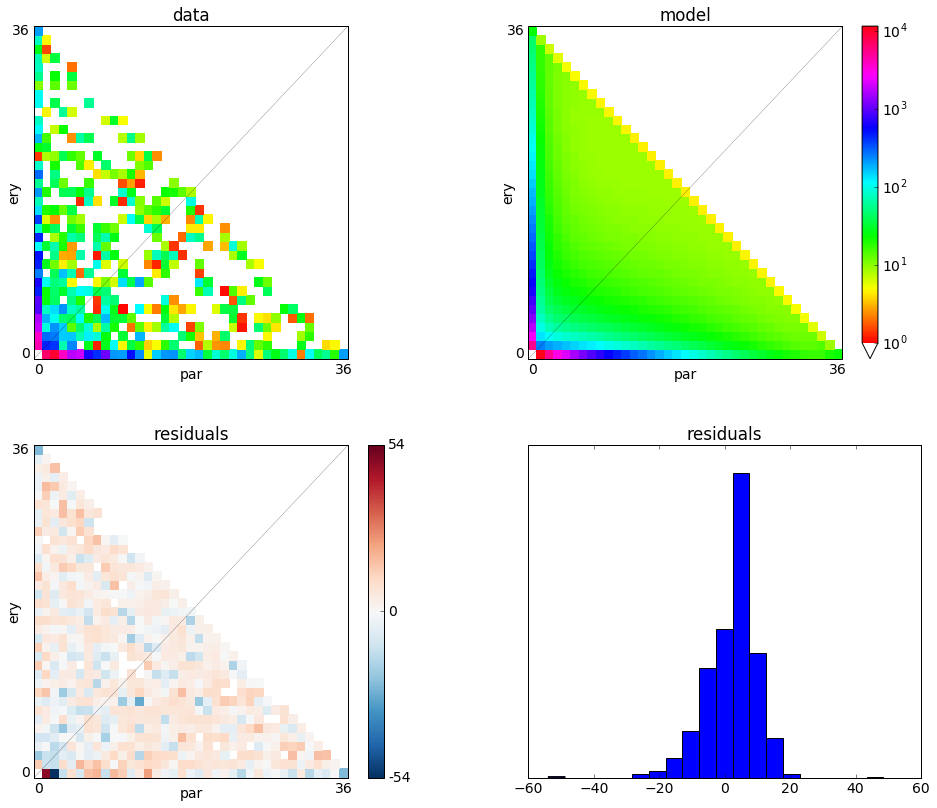

In [33]:
%matplotlib inline

import pylab

pylab.rcParams['figure.figsize'] = [14, 12]
pylab.rcParams['font.size'] = 14

dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d, vmin=1)

Plot residuals between IM models with symmetrical and asymmetrical migration.

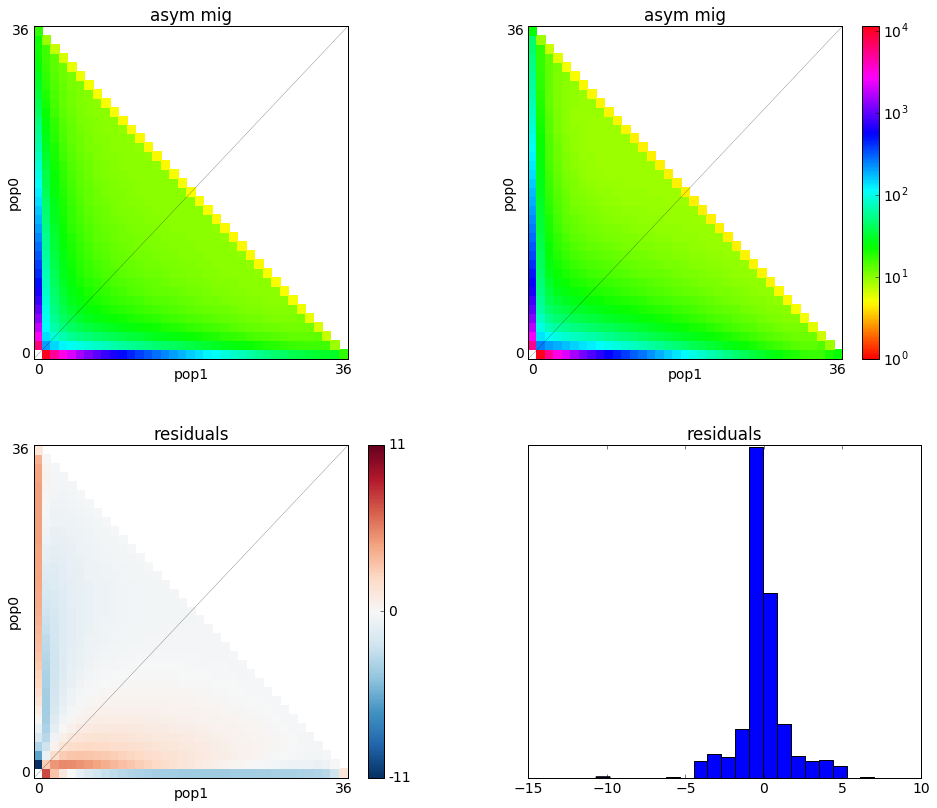

In [36]:
dadi.Plotting.plot_2d_comp_multinom(model=model_spectrum_asym_mig_scaled.fold(), \
                                    data=model_spectrum_sym_mig_scaled.fold(), vmin=1,\
                                   title=['sym mig', 'asym mig'])

The model spectrum for asymmetric gene flow has an excess (brown) of low to medium MAF SNP's in PAR that occur at low frequency in ERY.

In [40]:
popt_split_mig = popt_split_mig + [popt_split_mig[-1]]
popt_split_mig

[0.994185, 1.766127, 0.922632, 0.250688, 0.250688]

In [44]:
pd.DataFrame(data=np.array([popt_split_mig, popt]), index=['sym_mig', 'asym_mig'], columns=['nu1', 'nu2', 'T', 'm1', 'm2'])

,nu1,nu2,T,m1,m2
sym_mig,0.994185,1.766127,0.922632,0.250688,0.250688
asym_mig,0.920911,2.238617,1.244681,0.084147,0.494918


The excess of SNP's in MAF categroy 1 that did not introgress from PAR into ERY could be due to the greater population size increase inferred for PAR in the asymmetric gene flow model, although this model also inferred a greater time since the population size increase which should lead to greater equilibration of the initial rise in low frequency variants.

# two size changes after split

I would now like to add a gradual population size change after the split of the ancestral population. So far, the split coincided with a stepwise population size change.

In [1]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [3]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

error in importing Two Locus modules


In [4]:
%%px --local

# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

In [5]:
%%px --local

# add population labels
sfs2d_unfolded.pop_ids = ["ery", "par"]

sfs2d = sfs2d_unfolded.fold()

In [7]:
%psource dadi.Demographics2D.IM

Dadi's built-in `IM` model function contains what I would like to model now. To avoid confusion of migration rate parameters, I am anyway going to specify a slightly modified version of this model that uses the same naming convention and order of _m_ as used above.

In [6]:
def IM(params, ns, pts):
    """
    ns = (n1,n2)
    params = (s,nu1,nu2,T,m1,m2)

    Isolation-with-migration model with exponential pop growth or decline.

    s: Size of pop 1 after split. (Pop 2 has size 1-s.)
    nu1: Final size of pop 1.
    nu2: Final size of pop 2.
    T: Time in the past of split (in units of 2*Na generations) 
    m1: Migration from pop 1 to pop 2
    m2: Migration from pop 2 to pop 1 (2*Na*m12)
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    s,nu1,nu2,T,m1,m2 = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)

    nu1_func = lambda t: s * (nu1/s)**(t/T)
    nu2_func = lambda t: (1-s) * (nu2/(1-s))**(t/T)
    phi = dadi.Integration.two_pops(phi, xx, T, nu1_func, nu2_func,
                               m12=m2, m21=m1)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

In [7]:
%who

Client	 IM	 cl	 dadi	 numpy	 sfs2d	 sfs2d_unfolded	 sys	 


In [8]:
cl[:].push(dict(IM=IM))

<AsyncResult: _push>

In [9]:
%%px --local

func = IM

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [10]:
%%px --local

# set up global variables on engines required for run_dadi function call

ns = sfs2d.sample_sizes # both populations have the same sample size
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]
dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 300 # run a maximum of 300 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/IM" # set file name stub for opt. result files
fixed_params = None # do not fix any parameters, optimise all

In [11]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output, \
                        fixed_params=fixed_params)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [12]:
lbview = cl.load_balanced_view()

In [13]:
from itertools import repeat

In [14]:
%%px --local

# set lower and upper bounds to s, nu1, nu2, T, m1, m2
upper_bound = [1, 1e4, 1e4, 4, 10, 10] # note, I have increased the upper bound for T
lower_bound = [0, 1e-4, 1e-4, 0, 0, 0]

In [15]:
# using optimal parameter values from `split_asym_mig` model as starting values to perturb
p0 = [0.5, 0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818]

In [20]:
#ar_IM = lbview.map(run_dadi, repeat(p0, 10), block=False, order=False)

In [16]:
from utility_functions import *

In [24]:
ar_IM.done()

True

In [25]:
ar_IM.elapsed/60

54.9877662

It took almost 55 minutes to run these 10 optimisations!

In [27]:
get_flag_count(ar_IM, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


None of these iterations were successfull!

Let's have a look at the final parameters anyway.

In [17]:
from glob import glob
import dill

In [29]:
ar_IM_1 = []

for filename in glob("OUT_2D_models/IM*dill"):
    ar_IM_1.append(dill.load((open(filename))))

In [18]:
import pandas as pd

In [31]:
l = 2*len(p0)+1

returned = [flatten(out)[:l] for out in ar_IM_1]

df = pd.DataFrame(data=returned, columns=['s_0' ,'nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 's_opt' ,'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,s_0,nu1_0,nu2_0,T_0,m1_0,m2_0,s_opt,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
8,0.538469,1.255813,1.702693,0.635345,0.112638,0.259371,0.388115,1.063798,3.199012,3.234170,0.078406,0.557619,18814.877903
4,0.417002,0.379670,3.335798,1.655678,0.049658,0.456647,0.379121,1.082723,3.258400,3.404997,0.074637,0.545341,18815.329404
9,0.370682,0.321735,1.056795,0.583936,0.095256,0.255517,0.380064,1.084249,3.291107,3.415423,0.071002,0.551352,18815.491487
7,0.419080,0.329731,1.333254,0.328069,0.039567,0.583451,0.374416,0.861984,2.582981,2.194370,0.091604,0.687243,18824.198181
2,0.250917,1.848311,3.456539,3.836616,0.044460,1.623415,0.369875,0.847265,2.495861,1.992395,0.095853,0.694150,18827.183941
3,0.352691,0.420037,1.332921,1.209721,0.021299,1.610173,0.967013,0.426826,1.563459,3.937736,0.126149,1.350203,18872.325721
5,0.990000,1.262332,1.557653,0.404441,0.035836,0.379532,0.931879,0.497042,1.822031,3.908742,0.108858,1.162796,18873.343595
0,0.349074,0.946208,0.695694,1.037682,0.026119,0.684564,0.367520,0.831470,2.163526,1.064547,0.124656,0.680121,18922.856747
6,0.990000,0.618494,1.587982,0.834066,0.034694,0.726777,0.937755,0.255256,0.986855,1.923004,0.171459,2.263183,18928.836496
1,0.561863,3.449307,0.654947,3.505459,0.037483,0.875936,0.360894,0.970010,2.247817,1.386019,0.152528,0.521075,19022.057461


Note, that the _opt_ parameter values are just the final parameter values when the optimisation aborted. The parameter combinations with the highest likelihood have extremely long divergence time _T_. Also, the best-fit parameter combination of the `split_asym_mig` model above had log-likelihood of -18104, i. e. MUCH higher than the best parameter combination returned here.

In [32]:
cl[0]['fold']

2

In [33]:
cl[0]['maxiter']

300

In [34]:
%%px

fold = 1
maxiter = 500

In [35]:
#ar_IM = lbview.map(run_dadi, repeat(p0, 10), block=False, order=False)

In [36]:
ar_IM.done()

True

In [37]:
ar_IM.elapsed/60

25.25407435

In [38]:
get_flag_count(ar_IM, NM=True)

success 6
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 4
unknown flag 0


6 optimisations were successfull.

In [39]:
ar_IM_2 = []

for filename in glob("OUT_2D_models/IM*dill"):
    ar_IM_2.append(dill.load((open(filename))))

In [41]:
l = 2*len(p0)+1

success = [flatten(out)[:l] for out in ar_IM_2 if out[1][4] == 0]

df = pd.DataFrame(data=success, columns=['s_0' ,'nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 's_opt' ,'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,s_0,nu1_0,nu2_0,T_0,m1_0,m2_0,s_opt,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
1,0.691487,0.915053,3.337032,0.675904,0.163826,0.807328,0.401345,1.127900,3.433437,3.748322,0.069455,0.527414,18815.275911
0,0.480835,0.544289,2.698495,1.274298,0.108224,0.268005,0.386625,0.783977,2.312601,1.617469,0.106002,0.737586,18840.777647
2,0.311248,0.783400,1.527702,1.510593,0.097480,0.531996,0.379276,0.775452,2.276909,1.521873,0.107318,0.746463,18844.827051
5,0.256491,0.509203,1.193839,1.769454,0.052319,0.549816,0.360170,0.752934,2.103795,1.277866,0.118310,0.756747,18863.418261
4,0.340653,0.603664,2.743283,1.991499,0.100978,0.949964,0.389427,0.650453,2.072952,1.319869,0.093361,0.918291,18895.525183
3,0.724210,1.404692,1.981255,1.471683,0.043129,0.520545,0.432212,0.674174,1.857634,0.754107,0.141318,0.734668,18936.354679


The optimsations have not converged on a set of optimal parameter values.

In [42]:
cl[:]['fold']

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [43]:
p0

[0.5, 0.92091098, 2.2386172, 1.24468148, 0.08414741, 0.49491818]

In [44]:
%%px

fold = 1.5

In [45]:
ar_IM = lbview.map(run_dadi, repeat(p0, 20))

In [20]:
ar_IM_3 = []

for filename in glob("OUT_2D_models/IM*dill"):
    ar_IM_3.append(dill.load((open(filename))))

In [21]:
l = 2*len(p0)+1

success = [flatten(out)[:l] for out in ar_IM_3 if out[1][4] == 0]

df = pd.DataFrame(data=success, columns=['s_0' ,'nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 's_opt' ,'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,s_0,nu1_0,nu2_0,T_0,m1_0,m2_0,s_opt,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
5,0.345561,0.585417,1.192358,0.584863,0.042089,0.583673,0.409575,1.037432,3.163748,3.314343,0.075790,0.574198,18814.902965
4,0.691487,0.915053,3.337032,0.675904,0.163826,0.807328,0.401345,1.127900,3.433437,3.748322,0.069455,0.527414,18815.275911
2,0.231016,1.236144,1.875334,1.265815,0.065793,0.251310,0.389511,0.968089,2.940081,2.803636,0.082062,0.612002,18815.733030
13,0.222590,0.812110,1.404866,1.332359,0.031135,1.195093,0.424820,0.974611,3.066101,3.252257,0.074601,0.609123,18818.545393
8,0.874340,0.961087,3.051648,3.520197,0.075565,0.176083,0.497492,0.984338,3.197253,3.792882,0.069817,0.601396,18824.987400
6,0.588433,2.181412,2.425662,3.218246,0.032654,0.752488,0.567327,0.936764,3.089310,3.876621,0.073644,0.626325,18832.714699
0,0.480835,0.544289,2.698495,1.274298,0.108224,0.268005,0.386625,0.783977,2.312601,1.617469,0.106002,0.737586,18840.777647
7,0.311248,0.783400,1.527702,1.510593,0.097480,0.531996,0.379276,0.775452,2.276909,1.521873,0.107318,0.746463,18844.827051
15,0.256491,0.509203,1.193839,1.769454,0.052319,0.549816,0.360170,0.752934,2.103795,1.277866,0.118310,0.756747,18863.418261
9,0.767327,0.948644,2.160534,1.910986,0.054061,1.040162,0.371058,0.668971,2.138476,1.450574,0.090520,0.895524,18883.712912


This model is hard to fit to the data. The best-fit parameter combinations contain an extremely long divergence time _T_ of around 3, i. e. $6 \times N_{ref}$ generations. No parameter combination with higher likelihood could be found than in the previous runs and they are all much lower than from the `split_asym_mig` model (-18104), which imposed a stepwise size change coincident with the population split and otherwise constant population sizes. I do not understand why this more flexible model is so much harder to fit to the data.

In section 6, I have noticed that final parameter combinations from "unsuccessfull" optimisations can have higher likelihood than parameter combinations from successfull optimisations. I am therefore going to load the final parameter combinations from all "unsuccessfull" optimisations from file in order to check whether some have higher likelihood than the ones seen so far.

In [39]:
from glob import glob
import dill

In [41]:
ar_IM = []

for filename in glob("OUT_2D_models/IM*dill"):
    ar_IM.append(dill.load((open(filename))))

In [42]:
import pandas as pd

In [45]:
l = 2*6+1

# get all paramters returned from " unsuccessfull" optimisations into a table
returned = [flatten(out)[:l] for out in ar_IM if out[1][4] != 0]

df = pd.DataFrame(data=returned, columns=['s_0' ,'nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 's_opt' ,'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head()

,s_0,nu1_0,nu2_0,T_0,m1_0,m2_0,s_opt,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
13,0.287604,0.584816,2.491513,0.577716,0.154881,0.912029,0.394336,1.028757,3.117404,3.130620,0.077685,0.576641,18814.402521
0,0.463402,0.738050,3.905796,0.739800,0.058625,0.441791,0.406139,1.080665,3.270704,3.494185,0.074393,0.547156,18814.762357
20,0.538469,1.255813,1.702693,0.635345,0.112638,0.259371,0.388115,1.063798,3.199012,3.234170,0.078406,0.557619,18814.877903
10,0.417002,0.379670,3.335798,1.655678,0.049658,0.456647,0.379121,1.082723,3.258400,3.404997,0.074637,0.545341,18815.329404
22,0.370682,0.321735,1.056795,0.583936,0.095256,0.255517,0.380064,1.084249,3.291107,3.415423,0.071002,0.551352,18815.491487


No better parameter combinations can be found here.

In [23]:
import numpy as np

In [34]:
popt = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 6:12])
popt

array([ 0.40957519,  1.03743151,  3.16374756,  3.31434324,  0.07579024,
        0.57419769])

In [35]:
%psource IM

In [36]:
func_ex = dadi.Numerics.make_extrap_log_func(IM)

model_spectrum = func_ex(popt, ns, pts_l)

## Plot

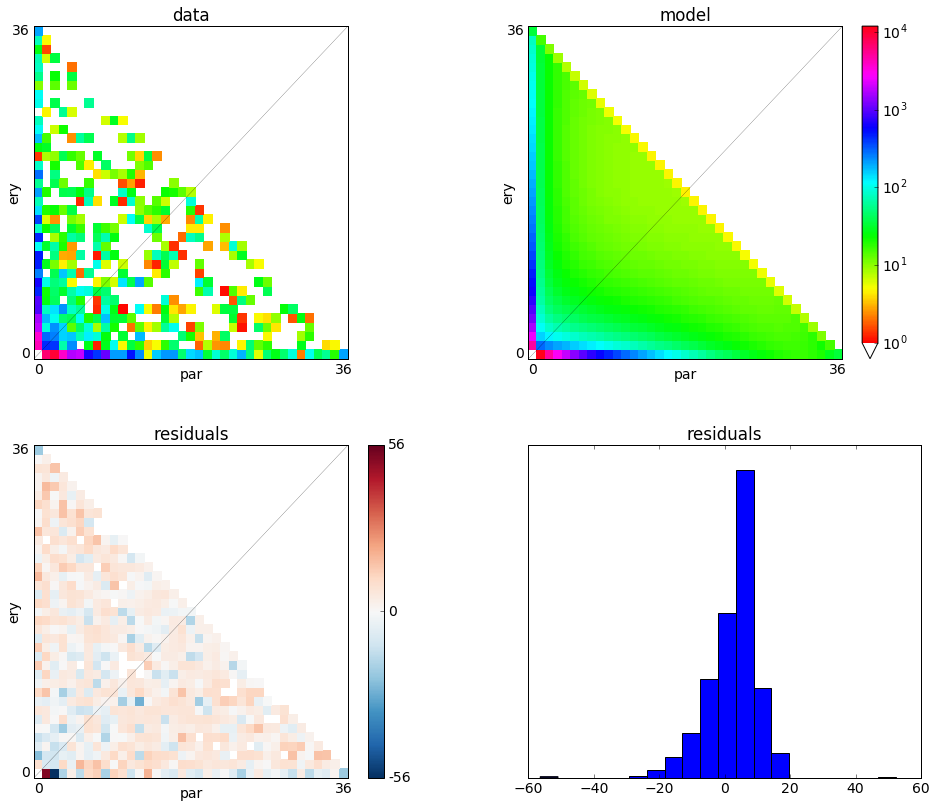

In [37]:
dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d, vmin=1)

I would like to see the difference in the expected spectra from the `split_asym_mig` and this `IM` model.

In [42]:
# optimally scale the best-fit IM model spectrum,
# by multiplication with optimal theta
model_spectrum = dadi.Inference.optimally_scaled_sfs(model_spectrum, sfs2d)

In [43]:
# make extraplating function from `split_asym_mig` model function
func_ex = dadi.Numerics.make_extrap_log_func(split_asym_mig)

# these were the optimal parameters for the `split_asym_mig` model
popt_asym_mig = [0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818]

# get (unsclaed) expected SFS for optimal `split_asym_mig` model
model_spectrum_asym_mig = func_ex(popt_asym_mig, ns, pts_l)

# optimally scale spectrum
model_spectrum_asym_mig = dadi.Inference.optimally_scaled_sfs(model_spectrum_asym_mig, sfs2d)

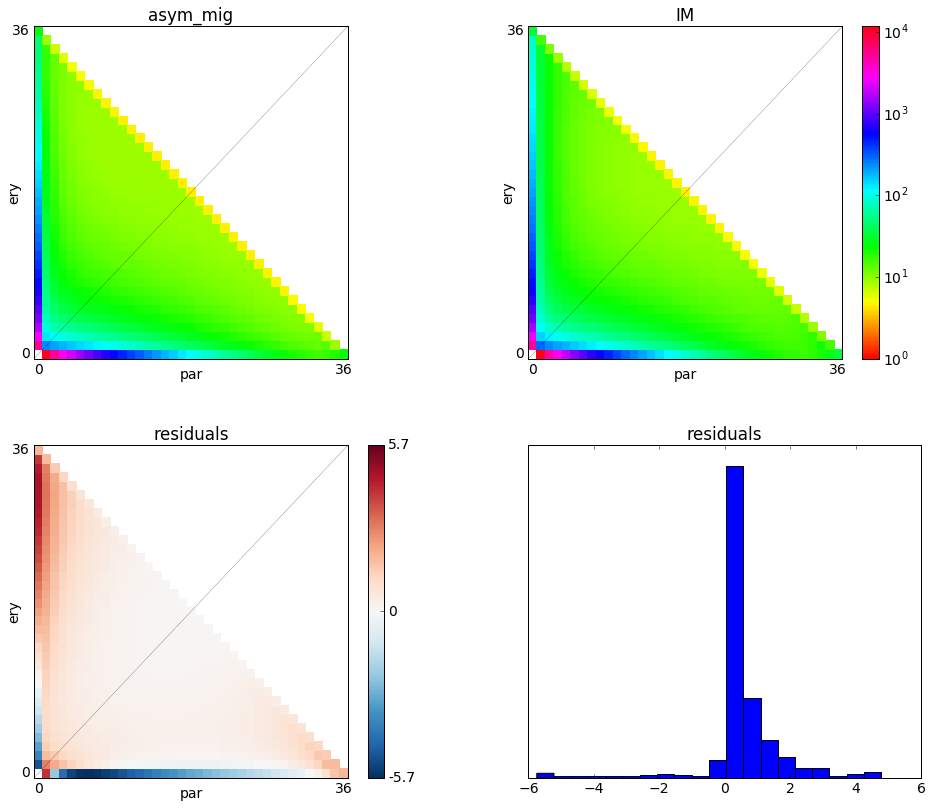

In [48]:
dadi.Plotting.plot_2d_comp_multinom(data=model_spectrum_asym_mig.fold(), model=model_spectrum.fold(), \
                                    vmin=1, title=['asym_mig', 'IM'], pop_ids=['ery', 'par'])

Looking at the residual plot, the `IM` model has a deficit (blue) of low frequency private alleles in par and an excess (red) of high frequency private alleles in ery.

# Ancient migration model

So far, a model with an ancient split and low but constant gene flow (more from par into ery than in the other direction) has fit the data best. I would like to know whether I can achieve an improvement if I let gene flow cease completely at some point in time.

In [1]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [2]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

error in importing Two Locus modules


In [3]:
%%px --local

# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

In [4]:
%%px --local

# add population labels
sfs2d_unfolded.pop_ids = ["ery", "par"]

sfs2d = sfs2d_unfolded.fold()

In [5]:
import numpy as np

In [10]:
def split_asym_mig_iso(params, ns, pts):
    """
    params = (nu1,nu2,Tc,m1,m2,Ti)
    ns = (n1,n2)

    Split into two populations of specifed size, with potentially asymmetric migration
    for a time Tc followed by complete isolation until present.

    nu1: Size of population 1 after split.
    nu2: Size of population 2 after split.
    Tc: Time of gene flow after split (in units of 2*Na generations) 
    m1: Migration rate from ery into par (in units of 2*Na ind per generation)
    m2: Migration rate from par into ery (in units of 2*Na ind per generation)
    Ti: Time of isolation after cessation of gene flow
    The split lies Tc+Ti * 2Na generations in the past.
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu1,nu2,Tc,m1,m2,Ti = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    
    # split
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi) 
    
    # divergence with potentially asymmetric migration
    phi = dadi.Integration.two_pops(phi, xx, Tc, nu1, nu2, m12=m2, m21=m1)
    
    # divergence without gene flow
    phi = dadi.Integration.two_pops(phi, xx, Ti, nu1, nu2, m12=0, m21=0)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

This is a piecewise model. I could make gene flow fade out gradually, but that would require four more parameters that specify the initial and final levels of gene flow. Also, it would make the model less comparable to the `split_asym_mig` model, which is also piecewise.

In [11]:
cl[:].push(dict(split_asym_mig_iso=split_asym_mig_iso))

<AsyncResult: _push>

In [12]:
%%px --local

func = split_asym_mig_iso

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [13]:
%%px --local

# set up global variables on engines required for run_dadi function call

ns = sfs2d.sample_sizes # both populations have the same sample size
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]
dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 300 # run a maximum of 300 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_asym_mig_iso" # set file name stub for opt. result files
fixed_params = None

In [14]:
%%px --local

# set lower and upper bounds to nu1, nu2, Tc, m1, m2 and Ti
upper_bound = [1e4, 1e4, 4, 10, 10, 4] # note, I have increased the upper bound for T
lower_bound = [1e-4, 1e-4, 0, 0, 0, 0]

In [15]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output, \
                        fixed_params=fixed_params)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [16]:
lbview = cl.load_balanced_view()

In [17]:
from itertools import repeat

In [21]:
# these were the optimal parameters for the `split_asym_mig` model
popt_asym_mig = [0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818]

p0 = [0.92091098,  2.2386172 ,  1.24468148/2,  0.08414741,  0.49491818, 1.24468148/2]

In [17]:
#ar_split_asym_mig_iso = lbview.map(run_dadi, repeat(p0, 10))

In [18]:
from utility_functions import *

In [19]:
get_flag_count(ar_split_asym_mig_iso, NM=True)

success 2
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 8
unknown flag 0


In [19]:
from glob import glob
import dill

ar_split_asym_mig_iso = []

for filename in glob("OUT_2D_models/split_asym_mig_iso*dill"):
    ar_split_asym_mig_iso.append(dill.load(open(filename)))

In [20]:
import pandas as pd

In [22]:
l = 2*len(p0)+1

# show only successfull optimisations
success = [flatten(out)[:l] for out in ar_split_asym_mig_iso if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,-logL
0,2.304194,4.429762,0.321067,0.088034,0.164105,1.145286,0.636636,1.230704,0.000361,0.000260,0.150317,0.290324,20387.374998
1,0.491139,8.116228,0.412795,0.028315,0.164313,1.385604,0.637813,1.229741,0.000072,0.508703,2.303400,0.290336,20387.455689


In [23]:
l = 2*len(p0)+1

# show parameter combinations from unsuccessfull optimisations:
returned = [flatten(out)[:l] for out in ar_split_asym_mig_iso if out[1][4] != 0]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,-logL
1,0.695160,1.910340,0.349480,0.079170,1.213752,0.452250,1.308976,3.255343,2.529225,7.601761e-02,0.512996,0.073343,17596.977545
3,0.671653,4.065260,2.194221,0.023455,0.353608,0.309520,1.282689,3.178194,2.456849,7.839336e-02,0.523647,0.071873,17598.109544
2,1.167491,2.210074,0.958929,0.029067,0.549556,0.158691,1.429102,3.584991,2.968951,6.605450e-02,0.457774,0.075285,17599.537780
7,2.441785,6.229020,0.730805,0.292610,0.622232,1.322095,1.220463,2.887035,2.149251,8.576529e-02,0.535093,0.060766,17614.184508
0,1.065453,6.333377,0.201816,0.038520,0.652852,0.315942,1.105729,2.695073,1.943358,9.068463e-02,0.606128,0.064713,17614.359180
6,2.649187,0.834484,0.679590,0.050556,1.111954,0.443331,1.039608,3.032459,1.984307,1.552506e-24,0.751166,0.062413,17930.613992
4,1.453066,2.898464,0.189121,0.062543,0.175887,0.213037,1.087550,3.193930,2.211338,3.755145e-05,0.749341,0.069638,17934.636212
5,0.392916,8.638236,0.548424,0.057429,0.832261,1.290279,0.637745,1.229895,0.000028,2.568636e-12,8.924231,0.290417,20387.440766


This is strange. "Unsuccessfull" optimisations (those which were aborted due to `Maximum number of iterations reached`) return parameter combinations that are much better than the two successfull optimisations!

**I wonder how many good parameter combinations I have missed due to my discarding of "unsuccessfull" optimisations!**

Fortunately, I have saved the results of _all_ optimisations to disk. So I can check each of my model optimisations for previously missed parameter combinbations that are better than the ones I have found so far.

The log likelihood of the `split_asym_mig` model with best-fit parameters was: -18104.966266885222

In [29]:
D = 2*(-17596.977545 - -18104.966266885222)
D

1015.97744377044

This ancient migration model fits the data significantly better than the `split_asym_mig` model. That also means that the recent period of complete isolation is significant. Assuming that I had found the best-fit parameters for that model, this means that a model that allows for a very ancient split (>1 million generations ago) and that specifies a recent cessation of gene flow fits the data better than a model with a less ancient split and constant migration until present.

Let's get a few more optimisation results.

In [24]:
p0 = np.array(df.sort_values(by='-logL', ascending=True).iloc[0,6:12])
p0

array([ 1.30897621,  3.25534314,  2.52922477,  0.07601761,  0.51299594,
        0.0733433 ])

In [25]:
ar_split_asym_mig_iso = lbview.map(run_dadi, repeat(p0, 10))

In [26]:
ar_split_asym_mig_iso.elapsed/60

11.90408875

In [27]:
ar_split_asym_mig_iso = []

for filename in glob("OUT_2D_models/split_asym_mig_iso*dill"):
    ar_split_asym_mig_iso.append(dill.load(open(filename)))

In [28]:
l = 2*len(p0)+1

# show all parameter combinations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_iso]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,-logL
18,4.519198,3.545465,3.960000,0.182724,0.328545,0.251493,1.724821,4.216882,3.678057,0.064336,0.396156,0.103548,17586.638813
5,0.695160,1.910340,0.349480,0.079170,1.213752,0.452250,1.308976,3.255343,2.529225,0.076018,0.512996,0.073343,17596.977545
19,2.290455,5.739002,1.606897,0.029919,0.482170,0.058327,1.305280,3.197046,2.481270,0.082010,0.522732,0.078352,17597.039999
9,0.671653,4.065260,2.194221,0.023455,0.353608,0.309520,1.282689,3.178194,2.456849,0.078393,0.523647,0.071873,17598.109544
6,1.167491,2.210074,0.958929,0.029067,0.549556,0.158691,1.429102,3.584991,2.968951,0.066055,0.457774,0.075285,17599.537780
2,1.829076,1.705655,3.960000,0.019067,0.842192,0.042996,1.130924,2.812528,2.015328,0.088408,0.592335,0.063364,17609.081716
17,2.441785,6.229020,0.730805,0.292610,0.622232,1.322095,1.220463,2.887035,2.149251,0.085765,0.535093,0.060766,17614.184508
1,1.065453,6.333377,0.201816,0.038520,0.652852,0.315942,1.105729,2.695073,1.943358,0.090685,0.606128,0.064713,17614.359180
10,0.932752,10.540588,1.824403,0.160051,0.458349,0.096989,0.925794,2.354674,1.503445,0.093921,0.719264,0.051874,17646.117157
0,2.216917,9.316636,1.197507,0.151019,0.291777,0.264858,0.860188,2.083049,1.160227,0.119236,0.762025,0.051645,17696.366407


There seems to be decent convergence. The long time inferred for the split ($T_c+T_i$) is worrying. I think it would be good to start a few more optimisations around the best parameter combination.

In [29]:
%%px 

fold = 1

In [30]:
p0 = np.array(df.sort_values(by='-logL', ascending=True).iloc[0,6:12])
p0

array([ 1.72482052,  4.21688238,  3.67805724,  0.06433563,  0.39615551,
        0.10354805])

In [31]:
ar_split_asym_mig_iso = lbview.map(run_dadi, repeat(p0, 10))

In [32]:
ar_split_asym_mig_iso = []

for filename in glob("OUT_2D_models/split_asym_mig_iso*dill"):
    ar_split_asym_mig_iso.append(dill.load(open(filename)))

In [33]:
l = 2*len(p0)+1

# show all parameter combinations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_iso]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,-logL
6,3.311864,5.144676,3.960000,0.109423,0.383802,0.129523,1.798721,4.397479,3.879859,0.061955,0.379276,0.107981,17585.882553
29,1.642916,6.103883,3.960000,0.054931,0.349428,0.058007,1.781764,4.362300,3.835582,0.062103,0.383396,0.106964,17586.026218
26,4.519198,3.545465,3.960000,0.182724,0.328545,0.251493,1.724821,4.216882,3.678057,0.064336,0.396156,0.103548,17586.638813
9,0.919254,3.900315,2.760405,0.117729,0.296027,0.089884,1.812170,4.400267,3.940908,0.062024,0.372393,0.108010,17586.805601
16,1.392965,3.383226,3.944028,0.052414,0.283459,0.073705,1.644600,4.027544,3.413685,0.066863,0.414662,0.098731,17587.978896
21,2.236010,2.136647,1.937628,0.095886,0.198439,0.059026,1.598186,3.923935,3.315448,0.068340,0.427212,0.095945,17588.376031
19,1.345651,2.234866,3.960000,0.035002,0.245472,0.081826,1.405393,3.451940,2.778376,0.076471,0.485692,0.084368,17592.877099
2,2.298750,5.108041,2.237167,0.071726,0.568041,0.171407,1.399617,3.439860,2.760202,0.076696,0.488590,0.084021,17593.096129
14,1.640028,6.001613,3.960000,0.078795,0.642601,0.093519,1.379659,3.393278,2.703678,0.076974,0.495791,0.082824,17593.774540
28,1.110873,7.672557,3.960000,0.063787,0.508132,0.083784,1.349127,3.342863,2.637726,0.080427,0.512762,0.080979,17596.732548


## plot

In [38]:
popt_mig_iso = np.array(df.sort_values(by='-logL', ascending=True).iloc[0,6:12])
popt_mig_iso

array([ 1.79872058,  4.39747881,  3.87985883,  0.06195513,  0.37927635,
        0.10798109])

In [39]:
model_mig_iso = func_ex(popt_mig_iso, ns, pts_l)

In [40]:
%matplotlib inline

import pylab

pylab.rcParams['figure.figsize'] = [14, 12]
pylab.rcParams['font.size'] = 14

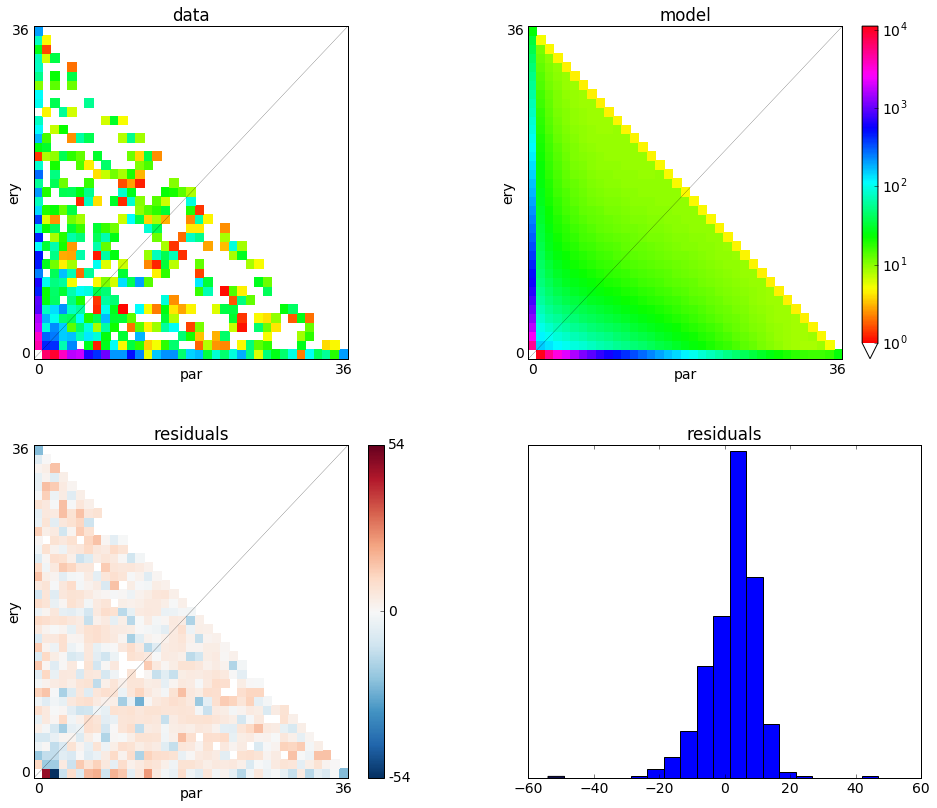

In [44]:
dadi.Plotting.plot_2d_comp_multinom(model=model_mig_iso, data=sfs2d, vmin=1)

## plain English

In [47]:
theta = dadi.Inference.optimal_sfs_scaling(model_mig_iso, sfs2d)
theta

2747.7501766405476

In [46]:
mu = 3e-9
L = sfs2d.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

The total sequence length for the 2D spectrum is 1,130,775.
The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: 202,497.


In [68]:
popt = popt_mig_iso
print "The ancestral population split apart {0:,} generations ago.".format(int((popt[2]+popt[5])*2*N_ref)),
print "Immediately after the split the ERY population changed to a size of {0:,} and the PAR population to {1:,}.".format(int(popt[0]*N_ref), int(popt[1]*N_ref)),
print "Since the split of the ancestral population, PAR received 1 individual from ERY every {0:.2f} generations,".format(1.0/(popt[3]/2*popt[1])),
print "while ERY received 1 PAR individual every {0:.2f} generations.".format(1.0/(popt[4]/2*popt[0])),
print "Put another way: The par population contained a constant proportion of {0:.2e} of new immigrant alleles each generation".format(popt[3]/2/N_ref),
print "and the ery population contained a constant proportion of {0:.2e} of new immigrant alleles each generation.".format(popt[4]/2/N_ref),
print "ERY and PAR remained in contact for {0:,} generations.".format(int(popt[2]*2*N_ref)),
print "{0:,} generations ago gene flow between ERY and PAR had ceased.".format(int(popt[5]*2*N_ref))

The ancestral population split apart 1,615,055 generations ago. Immediately after the split the ERY population changed to a size of 364,236 and the PAR population to 890,478. Since the split of the ancestral population, PAR received 1 individual from ERY every 7.34 generations, while ERY received 1 PAR individual every 2.93 generations. Put another way: The par population contained a constant proportion of 1.53e-07 of new immigrant alleles each generation and the ery population contained a constant proportion of 9.36e-07 of new immigrant alleles each generation. ERY and PAR remained in contact for 1,571,323 generations. 43,731 generations ago gene flow between ERY and PAR had ceased.


This is another indication that a recent secondary contact model is not compatible with the data. If the better fit of this ancient migration model (compared to constant migration) is not just due to fitting noise or biases in the data, then it would also mean that there is no detectable gene flow since the last ice age, despite the fact that the two populations are just a few kilometers apart and the clines of several markers are very wide across this transect of the hybrid zone.

## comparison with `split_asym_mig`

In [57]:
model_mig_iso_scaled = dadi.Inference.optimally_scaled_sfs(model_mig_iso, sfs2d)

In [59]:
func_ex = dadi.Numerics.make_extrap_log_func(split_asym_mig)

In [60]:
popt_asym_mig = [0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818]

In [61]:
model_asym_mig = func_ex(popt_asym_mig, ns, pts_l)

In [62]:
model_asym_mig_scaled = dadi.Inference.optimally_scaled_sfs(model_asym_mig, sfs2d)

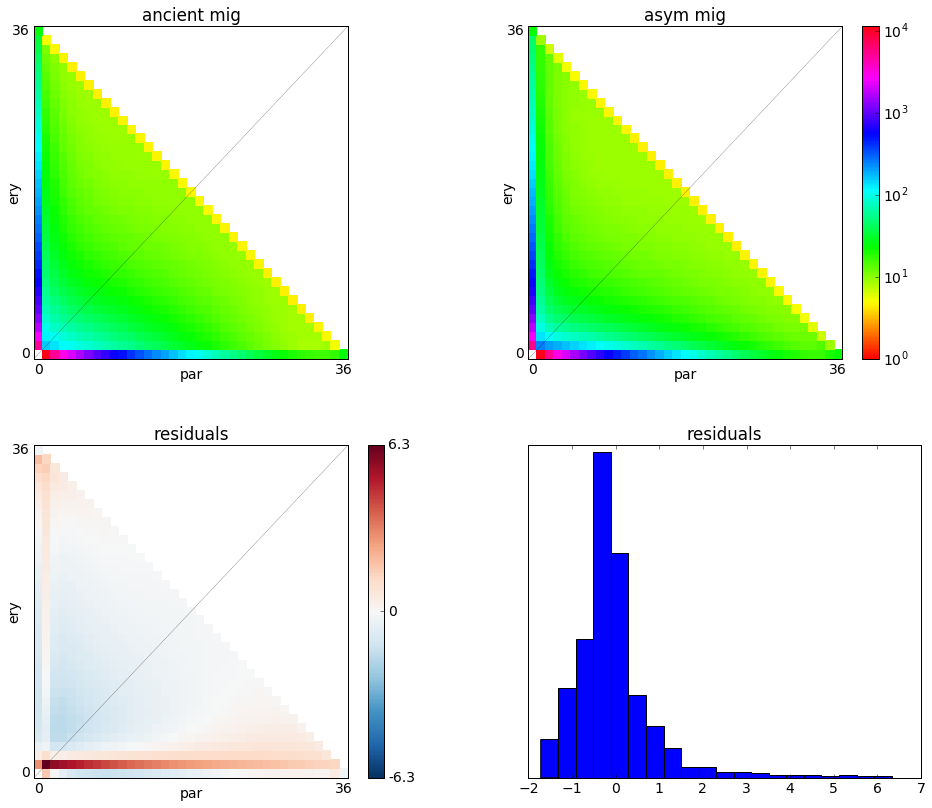

In [64]:
dadi.Plotting.plot_2d_comp_multinom(data=model_mig_iso_scaled.fold() , model=model_asym_mig_scaled.fold(), vmin=1, title=['ancient mig', 'asym mig'], pop_ids=['ery', 'par'])

Apparently the constant asymmetric migration model predicts many more variants at frequency 1 in erythropus than the ancient asymmetric migration model.